# Downloading and Caching Datasets

In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [2]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [3]:
def download_extract(name, folder=None):  #@save
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """Download all files in the DATA_HUB."""
    for name in DATA_HUB:
        download(name)

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from d2l import tensorflow as d2l

In [5]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

# Splitting Data

In [6]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [7]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [8]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

# Data Preprocessing

In [9]:
# If test data were inaccessible, mean and standard deviation could be
# calculated from training data
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing
# values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [10]:
# `Dummy_na=True` considers "na" (missing value) as a valid feature value, and
# creates an indicator feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

# Training

In [11]:
n_train = train_data.shape[0]
train_features = tf.constant(all_features[:n_train].values, dtype=tf.float32)
test_features = tf.constant(all_features[n_train:].values, dtype=tf.float32)
train_labels = tf.constant(train_data.SalePrice.values.reshape(-1, 1),
                           dtype=tf.float32)

In [12]:
loss = tf.keras.losses.MeanSquaredError()

def get_net():
    net = tf.keras.models.Sequential()
    net.add(
        tf.keras.layers.Dense(
            1, kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    return net

In [13]:
def log_rmse(y_true, y_pred):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = tf.clip_by_value(y_pred, 1, float('inf'))
    return tf.sqrt(
        tf.reduce_mean(loss(tf.math.log(y_true), tf.math.log(clipped_preds))))

In [14]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    net.compile(loss=loss, optimizer=optimizer)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                y_hat = net(X)
                l = loss(y, y_hat)
            params = net.trainable_variables
            grads = tape.gradient(l, params)
            optimizer.apply_gradients(zip(grads, params))
        train_ls.append(log_rmse(train_labels, net(train_features)))
        if test_labels is not None:
            test_ls.append(log_rmse(test_labels, net(test_features)))
    return train_ls, test_ls

# K-Fold Cross-Validation

In [15]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = tf.concat([X_train, X_part], 0)
            y_train = tf.concat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [16]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

# Model Selection

fold 1, train log rmse 0.169728, valid log rmse 0.156643
fold 2, train log rmse 0.162336, valid log rmse 0.190832
fold 3, train log rmse 0.163917, valid log rmse 0.168494
fold 4, train log rmse 0.167892, valid log rmse 0.154511
fold 5, train log rmse 0.162736, valid log rmse 0.182968
5-fold validation: avg train log rmse: 0.165322, avg valid log rmse: 0.170690


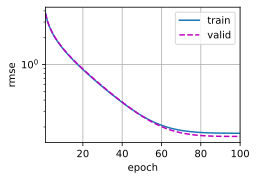

In [17]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

# Submitting Predictions on Kaggle

In [18]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # Apply the network to the test set
    preds = net(test_features).numpy()
    # Reformat it to export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train log rmse 0.162461


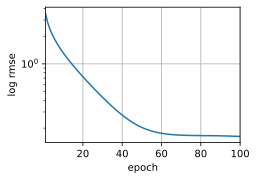

In [19]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

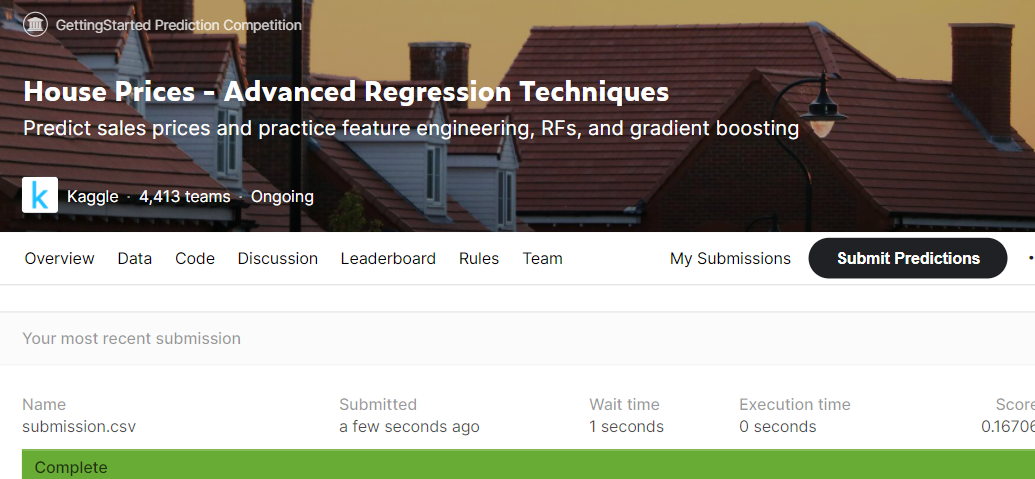

# Creating a DNN with Keras

In [20]:
import numpy as np
import pandas as pd
import tensorflow
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam 
import warnings
warnings.filterwarnings('ignore') 
n_train = train_data.shape[0]
X_train = all_features[:n_train].values
X_test = all_features[n_train:].values
Y_train = train_data.SalePrice.values.reshape(-1, 1)

In [21]:
def create_model(layers, optimizer):
    model = Sequential()
    model.add(Dense(320, input_dim=X_train.shape[1], activation='relu'))
    for i in range(layers):
        model.add(Dense(160, activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss = tensorflow.keras.losses.MeanSquaredLogarithmicError())
    return model

# Callbacks

### Early Stopping

In [22]:
model1 = create_model(5, optimizer=Adam(learning_rate=0.0001))
EarlyStopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model1.fit(x=X_train,y=Y_train,
          validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[EarlyStopping])
losses = pd.DataFrame(model1.history.history)

Epoch 1/1000
11/11 [==============================] - 0s 14ms/step - loss: 143.8127 - val_loss: 140.2239
Epoch 2/1000
11/11 [==============================] - 0s 5ms/step - loss: 138.3441 - val_loss: 133.6352
Epoch 3/1000
11/11 [==============================] - 0s 4ms/step - loss: 130.7829 - val_loss: 124.7610
Epoch 4/1000
11/11 [==============================] - 0s 4ms/step - loss: 120.9135 - val_loss: 113.8579
Epoch 5/1000
11/11 [==============================] - 0s 4ms/step - loss: 109.5730 - val_loss: 102.3386
Epoch 6/1000
11/11 [==============================] - 0s 4ms/step - loss: 98.2469 - val_loss: 91.5006
Epoch 7/1000
11/11 [==============================] - 0s 4ms/step - loss: 87.8566 - val_loss: 81.8243
Epoch 8/1000
11/11 [==============================] - 0s 4ms/step - loss: 78.6658 - val_loss: 73.3472
Epoch 9/1000
11/11 [==============================] - 0s 4ms/step - loss: 70.6231 - val_loss: 65.9483
Epoch 10/1000
11/11 [==============================] - 0s 4ms/step - lo

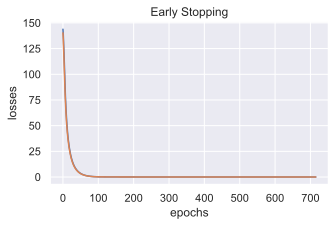

Loss =  0.013122239150106907
Val_Loss =  0.015277650207281113


In [23]:
fig, axes = plt.subplots(figsize=(5, 3))
axes.set_xlabel('epochs')
axes.set_ylabel('losses')
axes.plot(losses)
plt.title('Early Stopping')
plt.show()
print('Loss = ', history.history['loss'][-1:][0])
print('Val_Loss = ', history.history['val_loss'][-1:][0])

### LR Decay on Plateau

In [24]:
model2 = create_model(5, optimizer=Adam(learning_rate=0.0001))
ReduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', factor=0.2, mode='min',
                              patience=10, min_lr=0.00001)
history = model2.fit(x=X_train,y=Y_train, validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[ReduceLROnPlateau])
losses = pd.DataFrame(model2.history.history)

Epoch 1/1000
11/11 [==============================] - 0s 14ms/step - loss: 141.3345 - val_loss: 136.3880
Epoch 2/1000
11/11 [==============================] - 0s 4ms/step - loss: 133.3183 - val_loss: 126.9376
Epoch 3/1000
11/11 [==============================] - 0s 6ms/step - loss: 122.9479 - val_loss: 115.7581
Epoch 4/1000
11/11 [==============================] - 0s 5ms/step - loss: 111.5915 - val_loss: 104.5227
Epoch 5/1000
11/11 [==============================] - 0s 5ms/step - loss: 100.6081 - val_loss: 94.0388
Epoch 6/1000
11/11 [==============================] - 0s 4ms/step - loss: 90.5423 - val_loss: 84.5789
Epoch 7/1000
11/11 [==============================] - 0s 3ms/step - loss: 81.4943 - val_loss: 76.1308
Epoch 8/1000
11/11 [==============================] - 0s 4ms/step - loss: 73.4374 - val_loss: 68.6613
Epoch 9/1000
11/11 [==============================] - 0s 4ms/step - loss: 66.3526 - val_loss: 62.1570
Epoch 10/1000
11/11 [==============================] - 0s 3ms/step - los

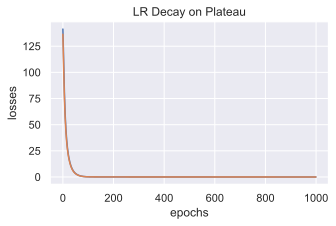

Loss =  0.012973671779036522
Val_Loss =  0.014516017399728298


In [25]:
fig, axes = plt.subplots(figsize=(5, 3))
axes.set_xlabel('epochs')
axes.set_ylabel('losses')
axes.plot(losses[['loss', 'val_loss']])
plt.title('LR Decay on Plateau')
plt.show()
print('Loss = ', history.history['loss'][-1:][0])
print('Val_Loss = ', history.history['val_loss'][-1:][0])

### ModelCheckpoint

In [26]:
model3 = create_model(5, optimizer=Adam(learning_rate=0.0001)) 
ModelCheckpoint = ModelCheckpoint(
    filepath= 'my_model.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model3.fit(x=X_train,y=Y_train, validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[ModelCheckpoint])
losses = pd.DataFrame(model3.history.history)

Epoch 1/1000
11/11 [==============================] - 0s 16ms/step - loss: 142.1157 - val_loss: 136.5119
Epoch 2/1000
11/11 [==============================] - 0s 4ms/step - loss: 133.3678 - val_loss: 127.3915
Epoch 3/1000
11/11 [==============================] - 0s 5ms/step - loss: 123.6403 - val_loss: 116.9617
Epoch 4/1000
11/11 [==============================] - 0s 5ms/step - loss: 113.0392 - val_loss: 106.2807
Epoch 5/1000
11/11 [==============================] - 0s 5ms/step - loss: 102.4355 - val_loss: 95.8967
Epoch 6/1000
11/11 [==============================] - 0s 7ms/step - loss: 92.3028 - val_loss: 86.3123
Epoch 7/1000
11/11 [==============================] - 0s 5ms/step - loss: 83.1615 - val_loss: 77.8255
Epoch 8/1000
11/11 [==============================] - 0s 5ms/step - loss: 75.0660 - val_loss: 70.3221
Epoch 9/1000
11/11 [==============================] - 0s 5ms/step - loss: 67.9450 - val_loss: 63.7610
Epoch 10/1000
11/11 [==============================] - 0s 6ms/step - los

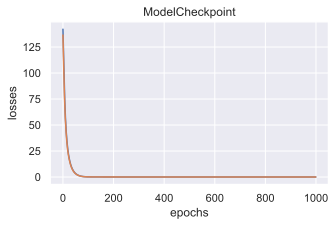

Loss =  0.008619948290288448
Val_Loss =  0.014527169056236744


In [27]:
fig, axes = plt.subplots(figsize=(5, 3))
axes.set_xlabel('epochs')
axes.set_ylabel('losses')
axes.plot(losses)
plt.title('ModelCheckpoint')
plt.show()
print('Loss = ', history.history['loss'][-1:][0])
print('Val_Loss = ', history.history['val_loss'][-1:][0])

In [28]:
print('LOSSES:')
print('EarlyStopping = ', model1.evaluate(X_train, Y_train, batch_size=128,verbose=0)) # EarlyStopping
print('ReduceLROnPlateau = ', model2.evaluate(X_train, Y_train, batch_size=128,verbose=0)) # ReduceLROnPlateau
print('ModelCheckpoint =', model3.evaluate(X_train, Y_train, batch_size=128,verbose=0)) # ModelCheckpoint

LOSSES:
EarlyStopping =  0.013313147239387035
ReduceLROnPlateau =  0.01312057301402092
ModelCheckpoint = 0.009190062060952187


# Setting TensorBoard

In [29]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import tensorflow as tf
import datetime

# Weights Initializations and Activation Functions

In [30]:
from tensorflow.keras.initializers import RandomNormal, GlorotNormal, HeNormal, LecunNormal
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects

def custom_gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

get_custom_objects().update({'custom_gelu': Activation(custom_gelu)})

RandomNormal = RandomNormal(mean=0., stddev=1.)
GlorotNormal = tf.keras.initializers.GlorotNormal()
HeNormal = tf.keras.initializers.HeNormal()
LecunNormal = tf.keras.initializers.LecunNormal()

RELU = 'relu'
SIGMOID = 'sigmoid'
TANH = 'tanh'
ELU = 'elu'
SELU = 'selu'
GELU = custom_gelu

In [31]:
def create_model(layers, optimizer, initializer, activation):
    model = Sequential()
    model.add(Dense(320, kernel_initializer=initializer, input_dim=X_train.shape[1], activation=activation))
    for i in range(layers):
        model.add(Dense(160, activation = activation))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss = tensorflow.keras.losses.MeanSquaredLogarithmicError())
    return model

### RandomNormal and RELU

In [32]:
model4 = create_model(5, Adam(learning_rate=0.0001), RandomNormal, RELU)

log_dir = "RandomNormal_RELU/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model4.fit(x=X_train,y=Y_train, validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[tensorboard_callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping])

losses = pd.DataFrame(model4.history.history)

Epoch 1/1000
 1/11 [=>............................] - ETA: 0s - loss: 140.4567WARNING:tensorflow:From C:\Users\Iryna.Dosiak\Anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
11/11 [==============================] - 0s 19ms/step - loss: 124.4132 - val_loss: 107.3483
Epoch 2/1000
11/11 [==============================] - 0s 6ms/step - loss: 101.6069 - val_loss: 93.3845
Epoch 3/1000
11/11 [==============================] - 0s 5ms/step - loss: 89.6300 - val_loss: 83.5022
Epoch 4/1000
11/11 [==============================] - 0s 5ms/step - loss: 80.4632 - val_loss: 75.3290
Epoch 5/1000
11/11 [==============================] - 0s 6ms/step - loss: 72.6916 - val_loss: 68.2106
Epoch 6/1000
11/11 [==============================] - 0s 6ms/step - loss: 65.9155 - val_loss: 61.9763
Epoch 7/1000
11/11 [==========

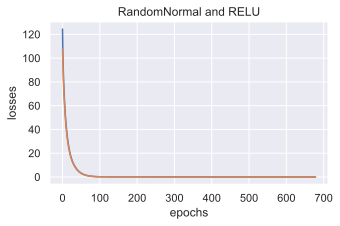

Loss =  0.01619201898574829
Val_Loss =  0.01961730793118477


In [33]:
fig, axes = plt.subplots(figsize=(5, 3))
axes.set_xlabel('epochs')
axes.set_ylabel('losses')
axes.plot(losses[['loss', 'val_loss']])
plt.title('RandomNormal and RELU')
plt.show()
print('Loss = ', history.history['loss'][-1:][0])
print('Val_Loss = ', history.history['val_loss'][-1:][0])

In [34]:
#%tensorboard --logdir RandomNormal_RELU/fit

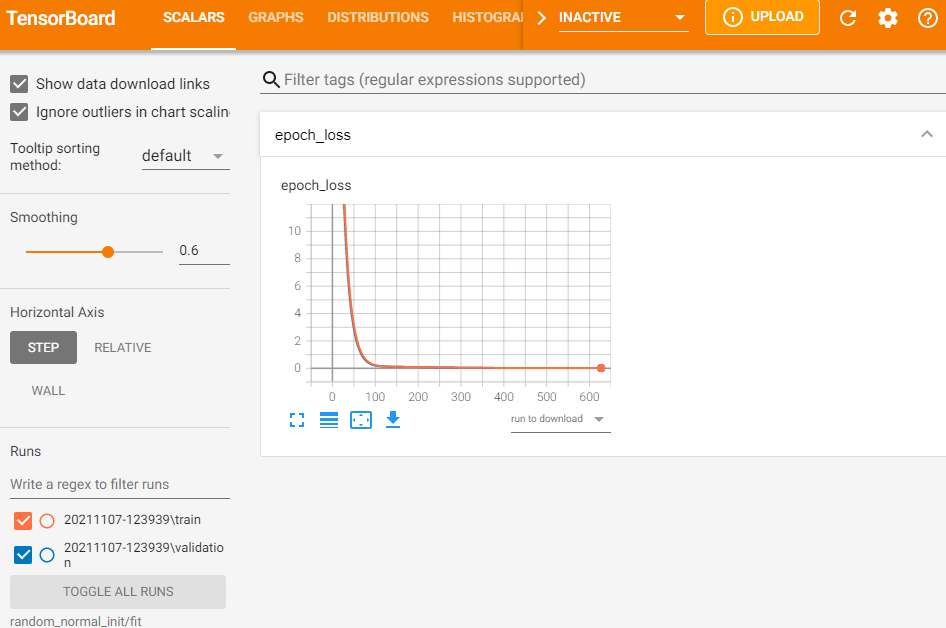

### RandomNormal and SIGMOID

In [35]:
model5 = create_model(5, Adam(learning_rate=0.0001), RandomNormal, SIGMOID)

log_dir = "RandomNormal_SIGMOID/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model5.fit(x=X_train,y=Y_train, validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[tensorboard_callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping])

losses = pd.DataFrame(model5.history.history)

Epoch 1/1000
11/11 [==============================] - 1s 58ms/step - loss: 135.9285 - val_loss: 131.3342
Epoch 2/1000
11/11 [==============================] - 0s 6ms/step - loss: 129.7697 - val_loss: 126.2977
Epoch 3/1000
11/11 [==============================] - 0s 6ms/step - loss: 125.3054 - val_loss: 122.5249
Epoch 4/1000
11/11 [==============================] - 0s 6ms/step - loss: 121.8903 - val_loss: 119.5482
Epoch 5/1000
11/11 [==============================] - 0s 7ms/step - loss: 119.1438 - val_loss: 117.0942
Epoch 6/1000
11/11 [==============================] - 0s 7ms/step - loss: 116.8454 - val_loss: 114.9993
Epoch 7/1000
11/11 [==============================] - 0s 5ms/step - loss: 114.8632 - val_loss: 113.1707
Epoch 8/1000
11/11 [==============================] - 0s 5ms/step - loss: 113.1204 - val_loss: 111.5475
Epoch 9/1000
11/11 [==============================] - 0s 6ms/step - loss: 111.5662 - val_loss: 110.0921
Epoch 10/1000
11/11 [==============================] - 0s 5ms/s

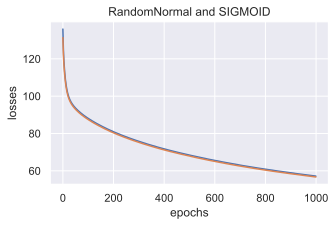

Loss =  57.18544387817383
Val_Loss =  56.71481704711914


In [36]:
fig, axes = plt.subplots(figsize=(5, 3))
axes.set_xlabel('epochs')
axes.set_ylabel('losses')
axes.plot(losses[['loss', 'val_loss']])
plt.title('RandomNormal and SIGMOID')
plt.show()
print('Loss = ', history.history['loss'][-1:][0])
print('Val_Loss = ', history.history['val_loss'][-1:][0])

In [38]:
#%tensorboard --logdir RandomNormal_SIGMOID/fit


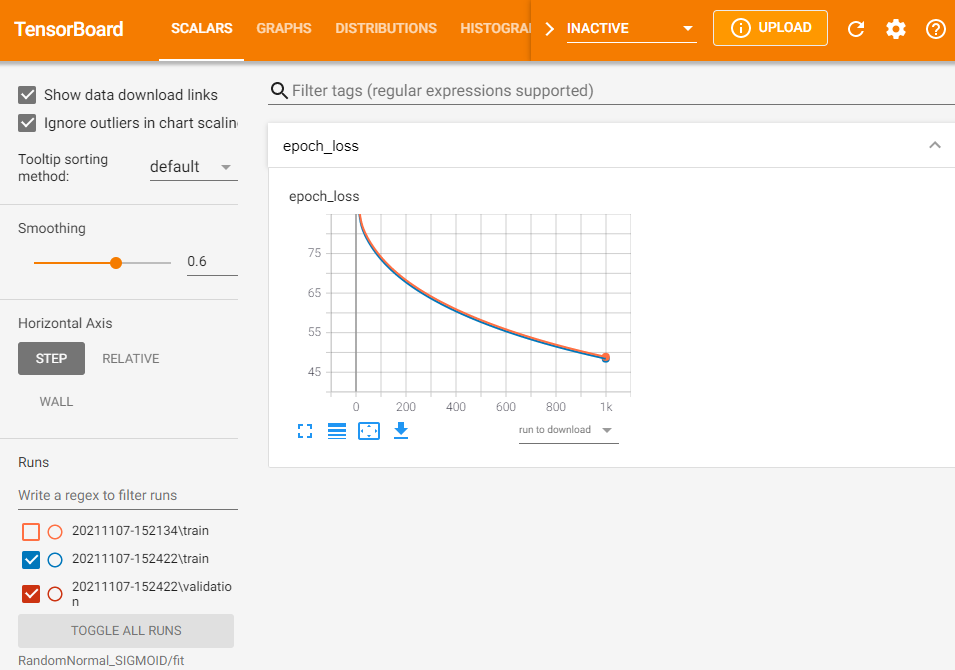

### RandomNormal and TANH

In [39]:
model6 = create_model(5, Adam(learning_rate=0.0001), RandomNormal, TANH)

log_dir = "RandomNormal_TANH/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model6.fit(x=X_train,y=Y_train, validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[tensorboard_callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping])

losses = pd.DataFrame(model6.history.history)

Epoch 1/1000
11/11 [==============================] - 1s 60ms/step - loss: 130.5741 - val_loss: 117.8414
Epoch 2/1000
11/11 [==============================] - 0s 6ms/step - loss: 113.2882 - val_loss: 107.1156
Epoch 3/1000
11/11 [==============================] - 0s 6ms/step - loss: 104.8459 - val_loss: 100.9118
Epoch 4/1000
11/11 [==============================] - 0s 6ms/step - loss: 99.6390 - val_loss: 96.8054
Epoch 5/1000
11/11 [==============================] - 0s 6ms/step - loss: 96.0740 - val_loss: 93.8793
Epoch 6/1000
11/11 [==============================] - 0s 6ms/step - loss: 93.4756 - val_loss: 91.6792
Epoch 7/1000
11/11 [==============================] - 0s 6ms/step - loss: 91.4911 - val_loss: 89.9711
Epoch 8/1000
11/11 [==============================] - 0s 6ms/step - loss: 89.9435 - val_loss: 88.6223
Epoch 9/1000
11/11 [==============================] - 0s 5ms/step - loss: 88.7147 - val_loss: 87.5518
Epoch 10/1000
11/11 [==============================] - 0s 7ms/step - loss: 

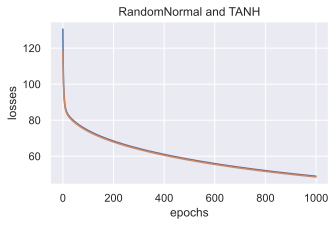

Loss =  48.92168426513672
Val_Loss =  48.48750305175781


In [40]:
fig, axes = plt.subplots(figsize=(5, 3))
axes.set_xlabel('epochs')
axes.set_ylabel('losses')
axes.plot(losses[['loss', 'val_loss']])
plt.title('RandomNormal and TANH')
plt.show()
print('Loss = ', history.history['loss'][-1:][0])
print('Val_Loss = ', history.history['val_loss'][-1:][0])

In [41]:
#%tensorboard --logdir RandomNormal_TANH/fit

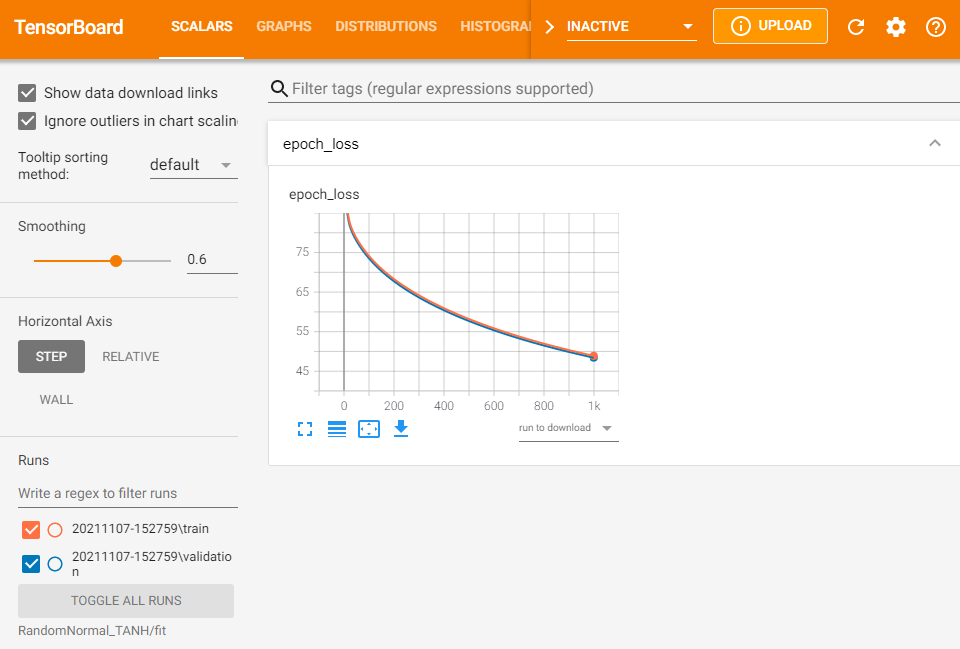

### RandomNormal and ELU


In [42]:
model7 = create_model(5, Adam(learning_rate=0.0001), RandomNormal, ELU)

log_dir = "RandomNormal_ELU/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model7.fit(x=X_train,y=Y_train, validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[tensorboard_callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping])

losses = pd.DataFrame(model7.history.history)

Epoch 1/1000
11/11 [==============================] - 1s 71ms/step - loss: 98.8622 - val_loss: 86.1010
Epoch 2/1000
11/11 [==============================] - 0s 7ms/step - loss: 82.1213 - val_loss: 76.1295
Epoch 3/1000
11/11 [==============================] - 0s 8ms/step - loss: 73.7571 - val_loss: 69.3663
Epoch 4/1000
11/11 [==============================] - 0s 7ms/step - loss: 67.6095 - val_loss: 63.9469
Epoch 5/1000
11/11 [==============================] - 0s 8ms/step - loss: 62.5002 - val_loss: 59.2592
Epoch 6/1000
11/11 [==============================] - 0s 9ms/step - loss: 57.9931 - val_loss: 55.0294
Epoch 7/1000
11/11 [==============================] - 0s 8ms/step - loss: 53.8859 - val_loss: 51.1218
Epoch 8/1000
11/11 [==============================] - 0s 8ms/step - loss: 50.0693 - val_loss: 47.4729
Epoch 9/1000
11/11 [==============================] - 0s 9ms/step - loss: 46.5024 - val_loss: 44.0708
Epoch 10/1000
11/11 [==============================] - 0s 10ms/step - loss: 43.18

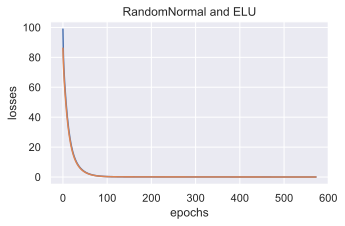

Loss =  0.019947541877627373
Val_Loss =  0.01995915174484253


In [43]:
fig, axes = plt.subplots(figsize=(5, 3))
axes.set_xlabel('epochs')
axes.set_ylabel('losses')
axes.plot(losses[['loss', 'val_loss']])
plt.title('RandomNormal and ELU')
plt.show()
print('Loss = ', history.history['loss'][-1:][0])
print('Val_Loss = ', history.history['val_loss'][-1:][0])

In [44]:
### RandomNormal and SELU

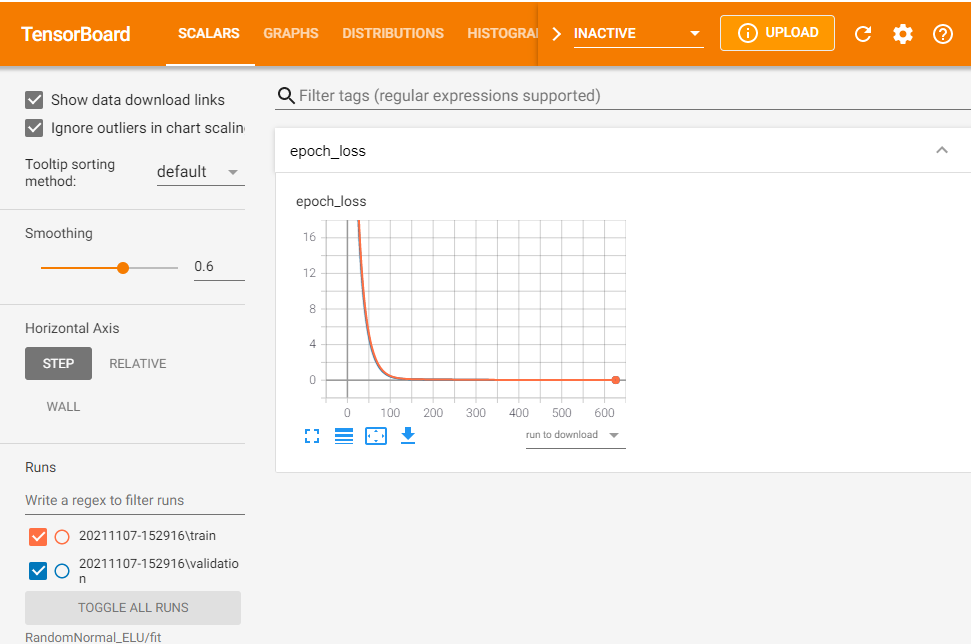

### RandomNormal and SELU

In [45]:
model8 = create_model(5, Adam(learning_rate=0.0001), RandomNormal, SELU)

log_dir = "RandomNormal_SELU/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model8.fit(x=X_train,y=Y_train, validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[tensorboard_callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping])

losses = pd.DataFrame(model8.history.history)

Epoch 1/1000
11/11 [==============================] - 1s 49ms/step - loss: 111.5233 - val_loss: 90.6861
Epoch 2/1000
11/11 [==============================] - 0s 6ms/step - loss: 86.0364 - val_loss: 79.6070
Epoch 3/1000
11/11 [==============================] - 0s 6ms/step - loss: 77.2095 - val_loss: 72.9490
Epoch 4/1000
11/11 [==============================] - 0s 7ms/step - loss: 71.2034 - val_loss: 67.7562
Epoch 5/1000
11/11 [==============================] - 0s 6ms/step - loss: 66.3262 - val_loss: 63.2745
Epoch 6/1000
11/11 [==============================] - 0s 6ms/step - loss: 62.0310 - val_loss: 59.2216
Epoch 7/1000
11/11 [==============================] - 0s 5ms/step - loss: 58.0929 - val_loss: 55.4508
Epoch 8/1000
11/11 [==============================] - 0s 7ms/step - loss: 54.4017 - val_loss: 51.8953
Epoch 9/1000
11/11 [==============================] - 0s 6ms/step - loss: 50.9060 - val_loss: 48.5245
Epoch 10/1000
11/11 [==============================] - 0s 6ms/step - loss: 47.59

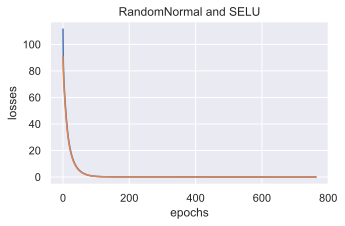

Loss =  0.01604512520134449
Val_Loss =  0.017794063314795494


In [46]:
fig, axes = plt.subplots(figsize=(5, 3))
axes.set_xlabel('epochs')
axes.set_ylabel('losses')
axes.plot(losses[['loss', 'val_loss']])
plt.title('RandomNormal and SELU')
plt.show()
print('Loss = ', history.history['loss'][-1:][0])
print('Val_Loss = ', history.history['val_loss'][-1:][0])

In [48]:
#%tensorboard --logdir RandomNormal_SELU/fit

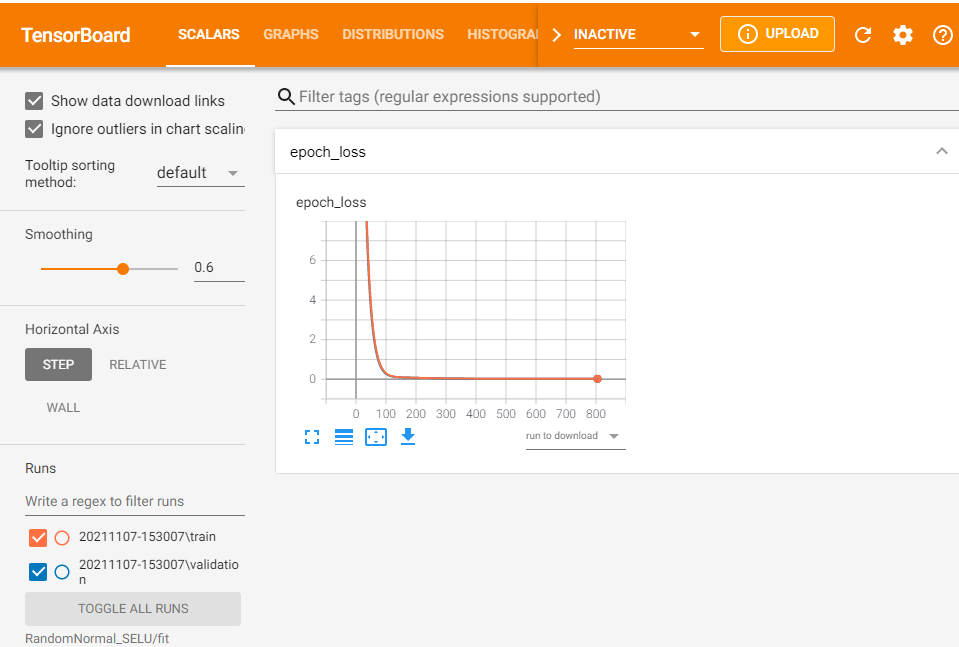

### RandomNormal and GELU

In [50]:
model9 = create_model(5, Adam(learning_rate=0.0001), RandomNormal, GELU)

log_dir = "RandomNormal_GELU/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model9.fit(x=X_train,y=Y_train, validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[tensorboard_callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping])

losses = pd.DataFrame(model9.history.history)

Epoch 1/1000
11/11 [==============================] - 1s 91ms/step - loss: 121.0865 - val_loss: 105.5126
Epoch 2/1000
11/11 [==============================] - 0s 6ms/step - loss: 100.4086 - val_loss: 92.6275
Epoch 3/1000
11/11 [==============================] - 0s 6ms/step - loss: 89.0583 - val_loss: 83.0700
Epoch 4/1000
11/11 [==============================] - 0s 6ms/step - loss: 80.2451 - val_loss: 75.2602
Epoch 5/1000
11/11 [==============================] - 0s 6ms/step - loss: 72.9667 - val_loss: 68.6684
Epoch 6/1000
11/11 [==============================] - 0s 6ms/step - loss: 66.7555 - val_loss: 62.9742
Epoch 7/1000
11/11 [==============================] - 0s 7ms/step - loss: 61.3289 - val_loss: 57.9236
Epoch 8/1000
11/11 [==============================] - 0s 6ms/step - loss: 56.4611 - val_loss: 53.3185
Epoch 9/1000
11/11 [==============================] - 0s 5ms/step - loss: 52.0037 - val_loss: 49.1047
Epoch 10/1000
11/11 [==============================] - 0s 7ms/step - loss: 47.

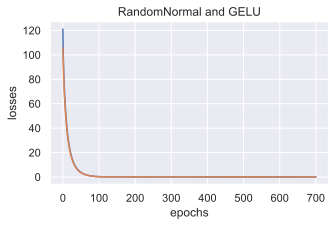

Loss =  0.016513695940375328
Val_Loss =  0.01674281246960163


In [51]:
fig, axes = plt.subplots(figsize=(5, 3))
axes.set_xlabel('epochs')
axes.set_ylabel('losses')
axes.plot(losses[['loss', 'val_loss']])
plt.title('RandomNormal and GELU')
plt.show()
print('Loss = ', history.history['loss'][-1:][0])
print('Val_Loss = ', history.history['val_loss'][-1:][0])

In [52]:
#%tensorboard --logdir RandomNormal_GELU/fit

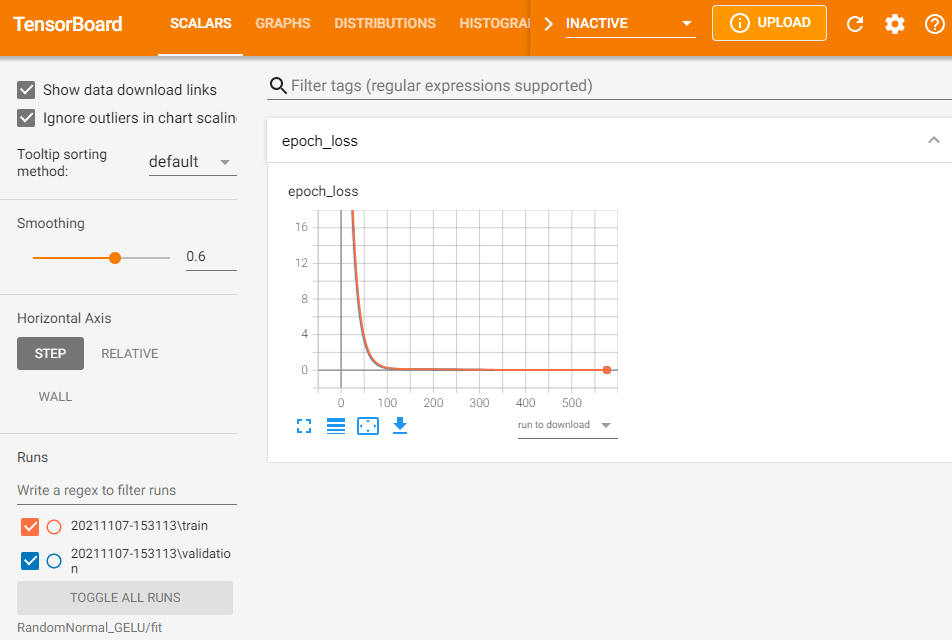

### GlorotNormal and RELU

In [55]:
model10 = create_model(5, Adam(learning_rate=0.0001), GlorotNormal, RELU)

log_dir = "GlorotNormal_RELU/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model10.fit(x=X_train,y=Y_train, validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[tensorboard_callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping])

losses = pd.DataFrame(model10.history.history)

Epoch 1/1000
11/11 [==============================] - 0s 44ms/step - loss: 139.8182 - val_loss: 134.1698
Epoch 2/1000
11/11 [==============================] - 0s 6ms/step - loss: 131.1290 - val_loss: 124.7010
Epoch 3/1000
11/11 [==============================] - 0s 6ms/step - loss: 121.0128 - val_loss: 114.1035
Epoch 4/1000
11/11 [==============================] - 0s 6ms/step - loss: 110.2857 - val_loss: 103.4321
Epoch 5/1000
11/11 [==============================] - 0s 6ms/step - loss: 99.8388 - val_loss: 93.5034
Epoch 6/1000
11/11 [==============================] - 0s 6ms/step - loss: 90.2953 - val_loss: 84.5910
Epoch 7/1000
11/11 [==============================] - 0s 5ms/step - loss: 81.7360 - val_loss: 76.6143
Epoch 8/1000
11/11 [==============================] - 0s 6ms/step - loss: 74.1094 - val_loss: 69.5275
Epoch 9/1000
11/11 [==============================] - 0s 6ms/step - loss: 67.3429 - val_loss: 63.2492
Epoch 10/1000
11/11 [==============================] - 0s 5ms/step - loss

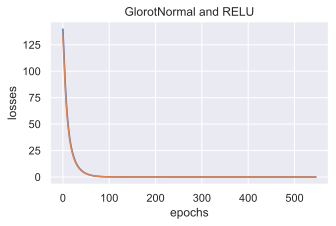

Loss =  0.015446821227669716
Val_Loss =  0.01633039489388466


In [56]:
fig, axes = plt.subplots(figsize=(5, 3))
axes.set_xlabel('epochs')
axes.set_ylabel('losses')
axes.plot(losses[['loss', 'val_loss']])
plt.title('GlorotNormal and RELU')
plt.show()
print('Loss = ', history.history['loss'][-1:][0])
print('Val_Loss = ', history.history['val_loss'][-1:][0])

In [57]:
#%tensorboard --logdir GlorotNormal_RELU/fit

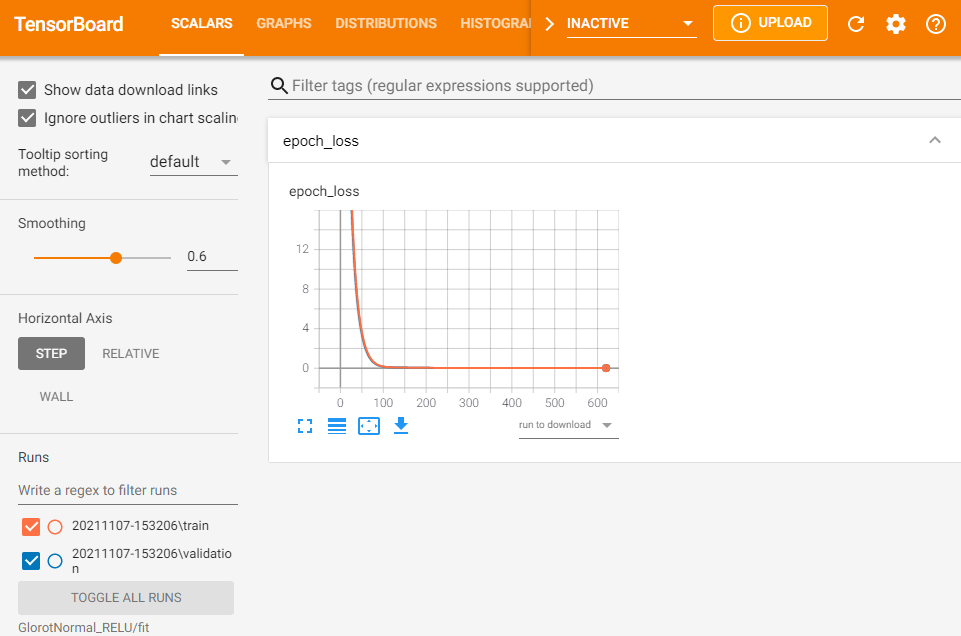

### GlorotNormal and SIGMOID

In [58]:
model11 = create_model(5, Adam(learning_rate=0.0001), GlorotNormal, SIGMOID)

log_dir = "GlorotNormal_SIGMOID/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model11.fit(x=X_train,y=Y_train, validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[tensorboard_callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping])

losses = pd.DataFrame(model11.history.history)

Epoch 1/1000
11/11 [==============================] - 1s 46ms/step - loss: 134.6371 - val_loss: 129.9224
Epoch 2/1000
11/11 [==============================] - 0s 6ms/step - loss: 128.3008 - val_loss: 124.7799
Epoch 3/1000
11/11 [==============================] - 0s 6ms/step - loss: 123.7604 - val_loss: 120.9612
Epoch 4/1000
11/11 [==============================] - 0s 6ms/step - loss: 120.3120 - val_loss: 117.9679
Epoch 5/1000
11/11 [==============================] - 0s 6ms/step - loss: 117.5570 - val_loss: 115.5111
Epoch 6/1000
11/11 [==============================] - 0s 6ms/step - loss: 115.2608 - val_loss: 113.4241
Epoch 7/1000
11/11 [==============================] - 0s 6ms/step - loss: 113.2888 - val_loss: 111.6076
Epoch 8/1000
11/11 [==============================] - 0s 6ms/step - loss: 111.5596 - val_loss: 110.0010
Epoch 9/1000
11/11 [==============================] - 0s 6ms/step - loss: 110.0221 - val_loss: 108.5625
Epoch 10/1000
11/11 [==============================] - 0s 6ms/s

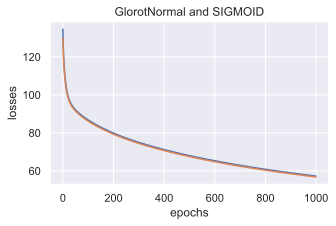

Loss =  57.26862335205078
Val_Loss =  56.79788589477539


In [59]:
fig, axes = plt.subplots(figsize=(5, 3))
axes.set_xlabel('epochs')
axes.set_ylabel('losses')
axes.plot(losses[['loss', 'val_loss']])
plt.title('GlorotNormal and SIGMOID')
plt.show()
print('Loss = ', history.history['loss'][-1:][0])
print('Val_Loss = ', history.history['val_loss'][-1:][0])

In [60]:
#%tensorboard --logdir GlorotNormal_SIGMOID/fit

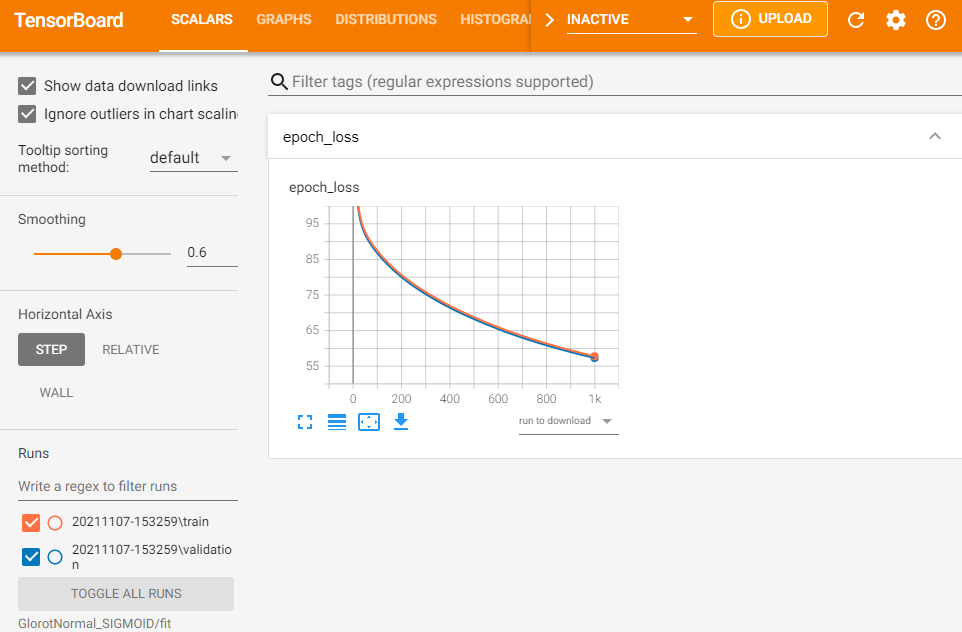

### GlorotNormal and TANH

In [61]:
model12 = create_model(5, Adam(learning_rate=0.0001), GlorotNormal, TANH)

log_dir = "GlorotNormal_TANH/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model12.fit(x=X_train,y=Y_train, validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[tensorboard_callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping])

losses = pd.DataFrame(model12.history.history)

Epoch 1/1000
11/11 [==============================] - 1s 63ms/step - loss: 128.0246 - val_loss: 115.9585
Epoch 2/1000
11/11 [==============================] - 0s 6ms/step - loss: 111.6718 - val_loss: 105.9231
Epoch 3/1000
11/11 [==============================] - 0s 6ms/step - loss: 103.7394 - val_loss: 100.1471
Epoch 4/1000
11/11 [==============================] - 0s 5ms/step - loss: 98.9551 - val_loss: 96.4506
Epoch 5/1000
11/11 [==============================] - 0s 6ms/step - loss: 95.8091 - val_loss: 93.8796
Epoch 6/1000
11/11 [==============================] - 0s 7ms/step - loss: 93.5628 - val_loss: 91.9875
Epoch 7/1000
11/11 [==============================] - 0s 6ms/step - loss: 91.8735 - val_loss: 90.5252
Epoch 8/1000
11/11 [==============================] - 0s 6ms/step - loss: 90.5521 - val_loss: 89.3573
Epoch 9/1000
11/11 [==============================] - 0s 6ms/step - loss: 89.4837 - val_loss: 88.4021
Epoch 10/1000
11/11 [==============================] - 0s 7ms/step - loss: 

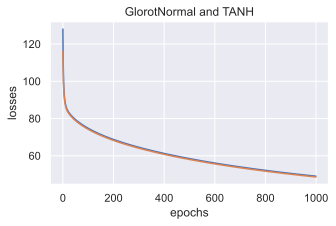

Loss =  49.02726745605469
Val_Loss =  48.59257125854492


In [62]:
fig, axes = plt.subplots(figsize=(5, 3))
axes.set_xlabel('epochs')
axes.set_ylabel('losses')
axes.plot(losses[['loss', 'val_loss']])
plt.title('GlorotNormal and TANH')
plt.show()
print('Loss = ', history.history['loss'][-1:][0])
print('Val_Loss = ', history.history['val_loss'][-1:][0])

In [63]:
#%tensorboard --logdir GlorotNormal_TANH/fit

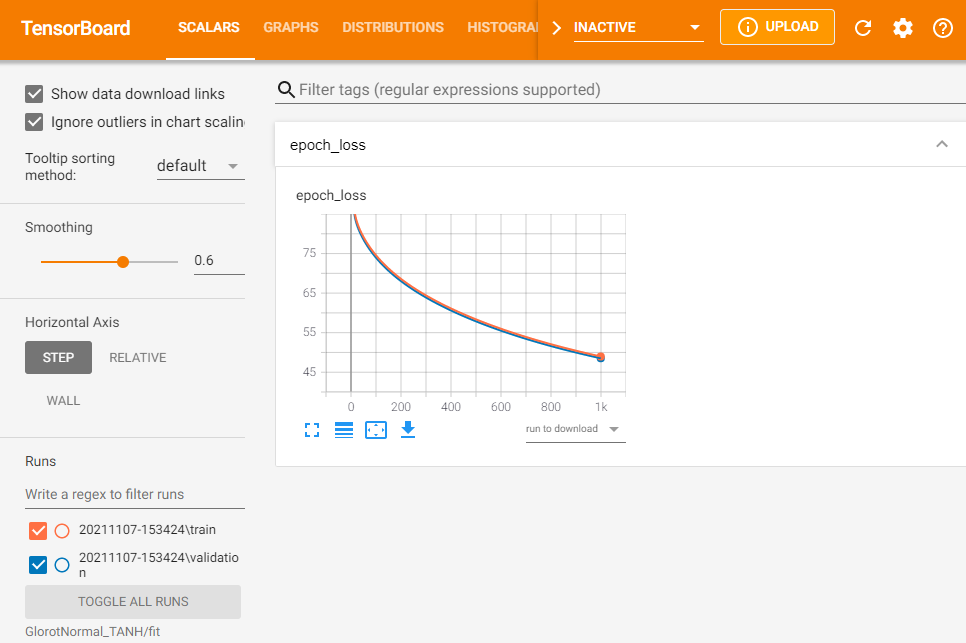

### GlorotNormal and ELU

In [64]:
model13 = create_model(5, Adam(learning_rate=0.0001), GlorotNormal, ELU)

log_dir = "GlorotNormal_ELU/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model13.fit(x=X_train,y=Y_train, validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[tensorboard_callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping])

losses = pd.DataFrame(model13.history.history)

Epoch 1/1000
11/11 [==============================] - 1s 73ms/step - loss: 129.8214 - val_loss: 116.5235
Epoch 2/1000
11/11 [==============================] - 0s 7ms/step - loss: 111.7136 - val_loss: 104.3586
Epoch 3/1000
11/11 [==============================] - 0s 8ms/step - loss: 101.2213 - val_loss: 95.7106
Epoch 4/1000
11/11 [==============================] - 0s 8ms/step - loss: 93.3565 - val_loss: 88.8294
Epoch 5/1000
11/11 [==============================] - 0s 7ms/step - loss: 86.9271 - val_loss: 83.0054
Epoch 6/1000
11/11 [==============================] - 0s 7ms/step - loss: 81.3796 - val_loss: 77.8544
Epoch 7/1000
11/11 [==============================] - 0s 10ms/step - loss: 76.4100 - val_loss: 73.1510
Epoch 8/1000
11/11 [==============================] - 0s 9ms/step - loss: 71.8218 - val_loss: 68.7613
Epoch 9/1000
11/11 [==============================] - 0s 8ms/step - loss: 67.5134 - val_loss: 64.6032
Epoch 10/1000
11/11 [==============================] - 0s 9ms/step - loss: 

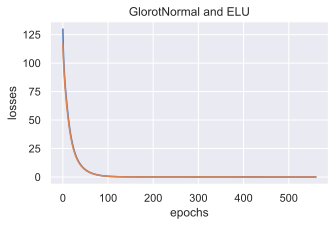

Loss =  0.01823381707072258
Val_Loss =  0.018122002482414246


In [65]:
fig, axes = plt.subplots(figsize=(5, 3))
axes.set_xlabel('epochs')
axes.set_ylabel('losses')
axes.plot(losses[['loss', 'val_loss']])
plt.title('GlorotNormal and ELU')
plt.show()
print('Loss = ', history.history['loss'][-1:][0])
print('Val_Loss = ', history.history['val_loss'][-1:][0])

In [66]:
#%tensorboard --logdir GlorotNormal_ELU/fit

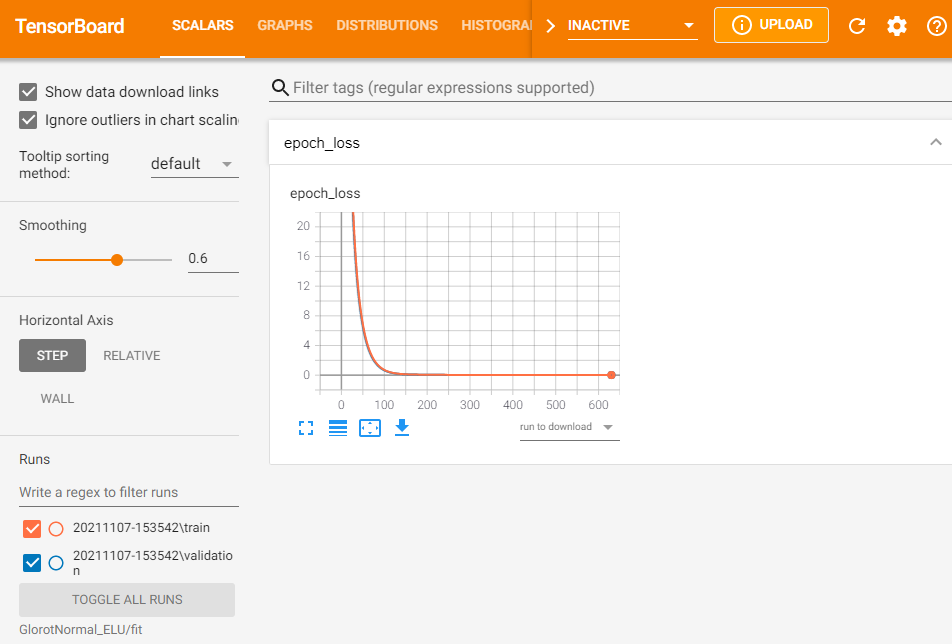

### GlorotNormal and SELU

In [67]:
model14 = create_model(5, Adam(learning_rate=0.0001), GlorotNormal, SELU)

log_dir = "GlorotNormal_SELU/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model14.fit(x=X_train,y=Y_train, validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[tensorboard_callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping])

losses = pd.DataFrame(model14.history.history)

Epoch 1/1000
11/11 [==============================] - 1s 51ms/step - loss: 116.7156 - val_loss: 98.2627
Epoch 2/1000
11/11 [==============================] - 0s 7ms/step - loss: 93.3355 - val_loss: 87.4023
Epoch 3/1000
11/11 [==============================] - 0s 7ms/step - loss: 84.9122 - val_loss: 81.1404
Epoch 4/1000
11/11 [==============================] - 0s 7ms/step - loss: 79.5329 - val_loss: 76.6478
Epoch 5/1000
11/11 [==============================] - 0s 7ms/step - loss: 75.4455 - val_loss: 72.9781
Epoch 6/1000
11/11 [==============================] - 0s 8ms/step - loss: 71.9999 - val_loss: 69.7702
Epoch 7/1000
11/11 [==============================] - 0s 7ms/step - loss: 68.9257 - val_loss: 66.8366
Epoch 8/1000
11/11 [==============================] - 0s 7ms/step - loss: 66.0600 - val_loss: 64.0510
Epoch 9/1000
11/11 [==============================] - 0s 7ms/step - loss: 63.3139 - val_loss: 61.3620
Epoch 10/1000
11/11 [==============================] - 0s 7ms/step - loss: 60.65

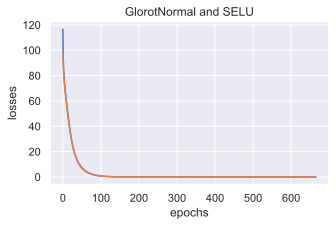

Loss =  0.017304206266999245
Val_Loss =  0.018536414951086044


In [68]:
fig, axes = plt.subplots(figsize=(5, 3))
axes.set_xlabel('epochs')
axes.set_ylabel('losses')
axes.plot(losses[['loss', 'val_loss']])
plt.title('GlorotNormal and SELU')
plt.show()
print('Loss = ', history.history['loss'][-1:][0])
print('Val_Loss = ', history.history['val_loss'][-1:][0])

In [69]:
#%tensorboard --logdir GlorotNormal_SELU/fit

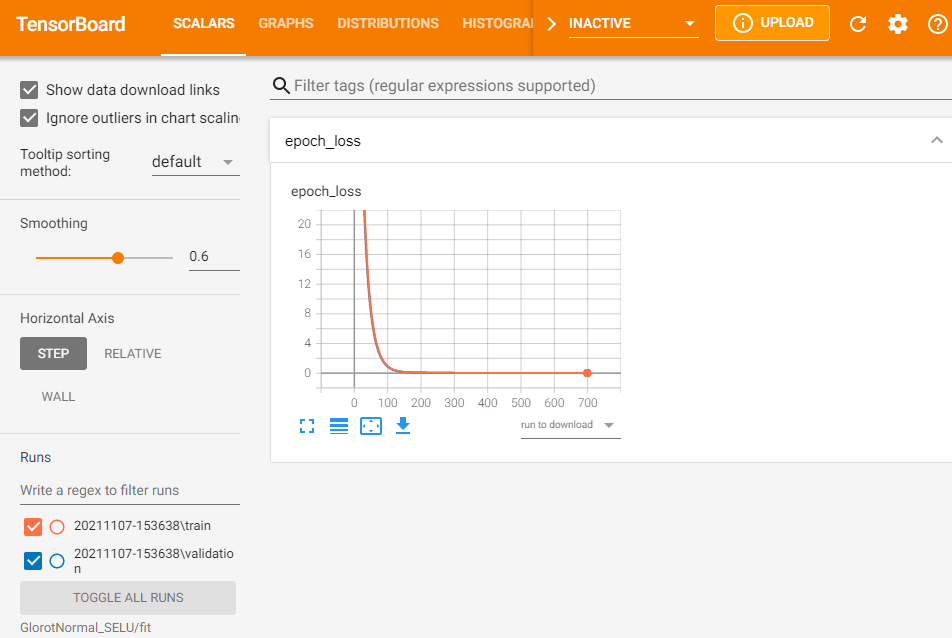

### GlorotNormal and GELU

In [70]:
model15 = create_model(5, Adam(learning_rate=0.0001), GlorotNormal, GELU)

log_dir = "GlorotNormal_GELU/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model15.fit(x=X_train,y=Y_train, validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[tensorboard_callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping])

losses = pd.DataFrame(model15.history.history)

Epoch 1/1000
11/11 [==============================] - 1s 70ms/step - loss: 143.8721 - val_loss: 141.6341
Epoch 2/1000
11/11 [==============================] - 0s 7ms/step - loss: 140.8034 - val_loss: 137.2752
Epoch 3/1000
11/11 [==============================] - 0s 7ms/step - loss: 134.9918 - val_loss: 129.0651
Epoch 4/1000
11/11 [==============================] - 0s 7ms/step - loss: 124.7956 - val_loss: 116.2214
Epoch 5/1000
11/11 [==============================] - 0s 7ms/step - loss: 110.6184 - val_loss: 101.0580
Epoch 6/1000
11/11 [==============================] - 0s 7ms/step - loss: 95.8221 - val_loss: 87.6249
Epoch 7/1000
11/11 [==============================] - 0s 8ms/step - loss: 83.7104 - val_loss: 77.3747
Epoch 8/1000
11/11 [==============================] - 0s 8ms/step - loss: 74.3856 - val_loss: 69.1939
Epoch 9/1000
11/11 [==============================] - 0s 8ms/step - loss: 66.7690 - val_loss: 62.3466
Epoch 10/1000
11/11 [==============================] - 0s 8ms/step - lo

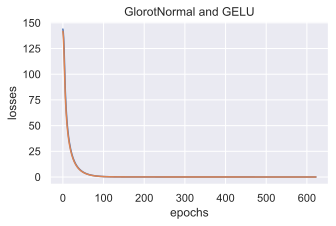

Loss =  0.017059922218322754
Val_Loss =  0.017735183238983154


In [71]:
fig, axes = plt.subplots(figsize=(5, 3))
axes.set_xlabel('epochs')
axes.set_ylabel('losses')
axes.plot(losses[['loss', 'val_loss']])
plt.title('GlorotNormal and GELU')
plt.show()
print('Loss = ', history.history['loss'][-1:][0])
print('Val_Loss = ', history.history['val_loss'][-1:][0])

In [72]:
#%tensorboard --logdir GlorotNormal_GELU/fit

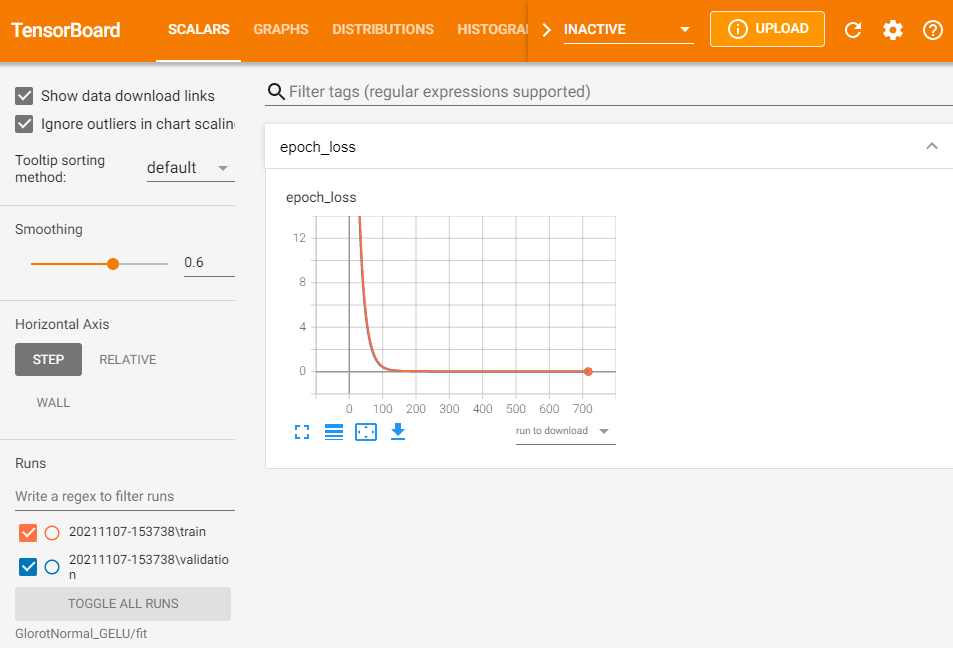

### HeNormal and RELU

In [73]:
model16 = create_model(5, Adam(learning_rate=0.0001), HeNormal, RELU)

log_dir = "HeNormal_RELU/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model16.fit(x=X_train,y=Y_train, validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[tensorboard_callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping])

losses = pd.DataFrame(model16.history.history)

Epoch 1/1000
11/11 [==============================] - 1s 50ms/step - loss: 140.5532 - val_loss: 134.6963
Epoch 2/1000
11/11 [==============================] - 0s 6ms/step - loss: 131.3795 - val_loss: 124.8708
Epoch 3/1000
11/11 [==============================] - 0s 6ms/step - loss: 121.1301 - val_loss: 114.1331
Epoch 4/1000
11/11 [==============================] - 0s 6ms/step - loss: 110.1465 - val_loss: 103.1248
Epoch 5/1000
11/11 [==============================] - 0s 6ms/step - loss: 99.3372 - val_loss: 92.8130
Epoch 6/1000
11/11 [==============================] - 0s 6ms/step - loss: 89.3994 - val_loss: 83.4837
Epoch 7/1000
11/11 [==============================] - 0s 6ms/step - loss: 80.4947 - val_loss: 75.2527
Epoch 8/1000
11/11 [==============================] - 0s 6ms/step - loss: 72.6380 - val_loss: 67.9816
Epoch 9/1000
11/11 [==============================] - 0s 6ms/step - loss: 65.6884 - val_loss: 61.5284
Epoch 10/1000
11/11 [==============================] - 0s 6ms/step - loss

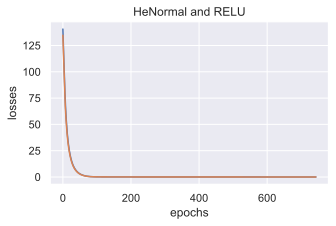

Loss =  0.014777080155909061
Val_Loss =  0.01571108214557171


In [74]:
fig, axes = plt.subplots(figsize=(5, 3))
axes.set_xlabel('epochs')
axes.set_ylabel('losses')
axes.plot(losses[['loss', 'val_loss']])
plt.title('HeNormal and RELU')
plt.show()
print('Loss = ', history.history['loss'][-1:][0])
print('Val_Loss = ', history.history['val_loss'][-1:][0])

In [75]:
#%tensorboard --logdir HeNormal_RELU/fit

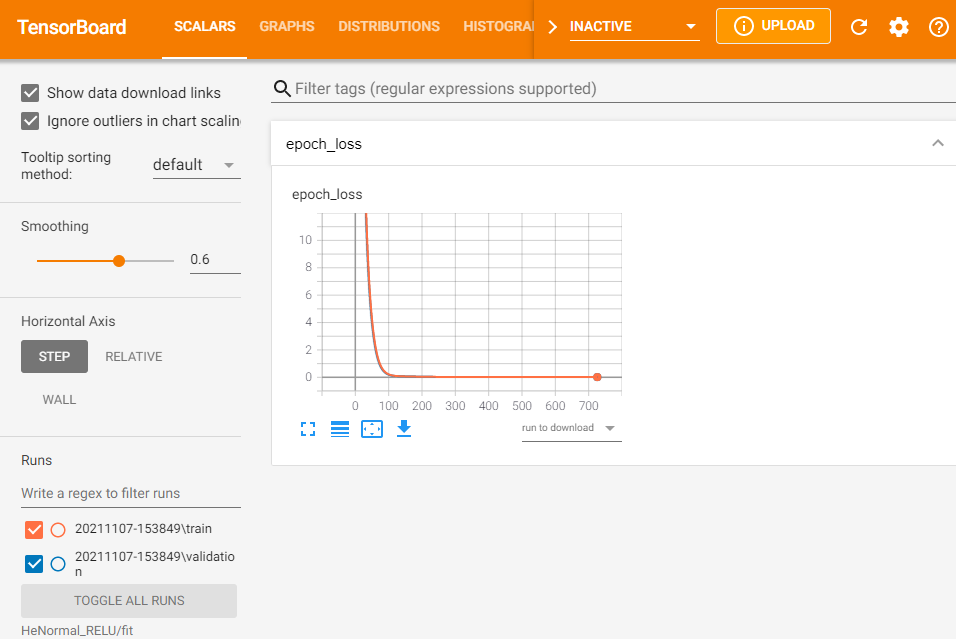

In [76]:
### HeNormal and SIGMOID

In [77]:
model17 = create_model(5, Adam(learning_rate=0.0001), HeNormal, SIGMOID)

log_dir = "HeNormal_SIGMOID/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model17.fit(x=X_train,y=Y_train, validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[tensorboard_callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping])

losses = pd.DataFrame(model17.history.history)

Epoch 1/1000
11/11 [==============================] - 1s 47ms/step - loss: 133.9719 - val_loss: 129.0647
Epoch 2/1000
11/11 [==============================] - 0s 7ms/step - loss: 127.3624 - val_loss: 123.7673
Epoch 3/1000
11/11 [==============================] - 0s 6ms/step - loss: 122.7150 - val_loss: 119.8885
Epoch 4/1000
11/11 [==============================] - 0s 7ms/step - loss: 119.2273 - val_loss: 116.8763
Epoch 5/1000
11/11 [==============================] - 0s 6ms/step - loss: 116.4604 - val_loss: 114.4169
Epoch 6/1000
11/11 [==============================] - 0s 7ms/step - loss: 114.1635 - val_loss: 112.3300
Epoch 7/1000
11/11 [==============================] - 0s 7ms/step - loss: 112.1917 - val_loss: 110.5137
Epoch 8/1000
11/11 [==============================] - 0s 7ms/step - loss: 110.4614 - val_loss: 108.9050
Epoch 9/1000
11/11 [==============================] - 0s 7ms/step - loss: 108.9207 - val_loss: 107.4613
Epoch 10/1000
11/11 [==============================] - 0s 7ms/s

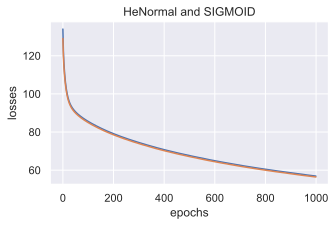

Loss =  56.90632629394531
Val_Loss =  56.43711853027344


In [78]:
fig, axes = plt.subplots(figsize=(5, 3))
axes.set_xlabel('epochs')
axes.set_ylabel('losses')
axes.plot(losses[['loss', 'val_loss']])
plt.title('HeNormal and SIGMOID')
plt.show()
print('Loss = ', history.history['loss'][-1:][0])
print('Val_Loss = ', history.history['val_loss'][-1:][0])

In [79]:
#%tensorboard --logdir HeNormal_SIGMOID/fit

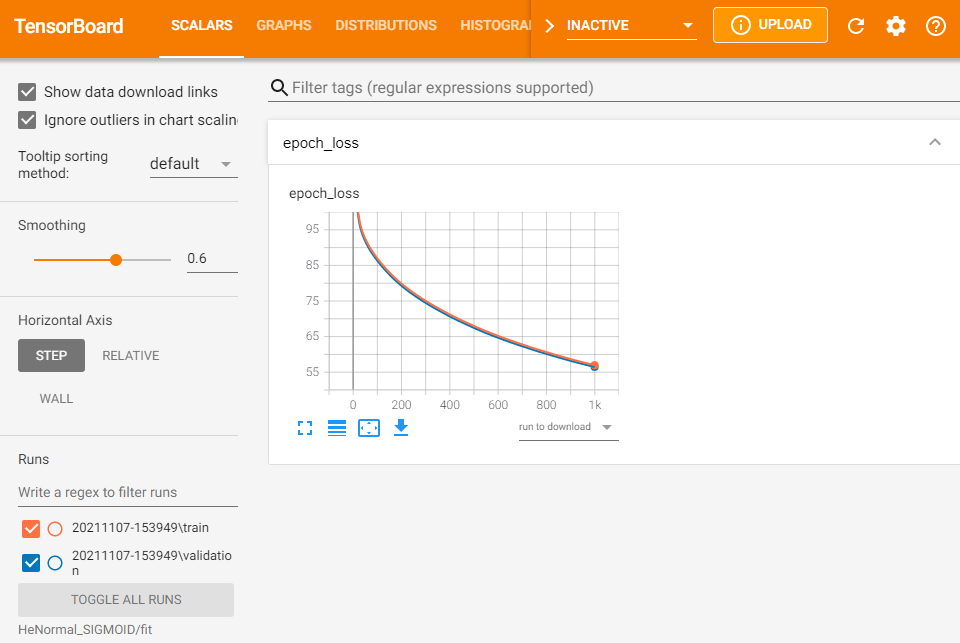

### HeNormal and TANH

In [80]:
model18 = create_model(5, Adam(learning_rate=0.0001), HeNormal, TANH)

log_dir = "HeNormal_TANH/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model18.fit(x=X_train,y=Y_train, validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[tensorboard_callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping])

losses = pd.DataFrame(model18.history.history)

Epoch 1/1000
11/11 [==============================] - 1s 68ms/step - loss: 122.8463 - val_loss: 112.1780
Epoch 2/1000
11/11 [==============================] - 0s 7ms/step - loss: 108.4986 - val_loss: 103.1859
Epoch 3/1000
11/11 [==============================] - 0s 7ms/step - loss: 101.1754 - val_loss: 97.6618
Epoch 4/1000
11/11 [==============================] - 0s 7ms/step - loss: 96.5112 - val_loss: 93.9931
Epoch 5/1000
11/11 [==============================] - 0s 7ms/step - loss: 93.3651 - val_loss: 91.4383
Epoch 6/1000
11/11 [==============================] - 0s 7ms/step - loss: 91.1404 - val_loss: 89.5883
Epoch 7/1000
11/11 [==============================] - 0s 7ms/step - loss: 89.5026 - val_loss: 88.1880
Epoch 8/1000
11/11 [==============================] - 0s 7ms/step - loss: 88.2463 - val_loss: 87.0952
Epoch 9/1000
11/11 [==============================] - 0s 7ms/step - loss: 87.2557 - val_loss: 86.2290
Epoch 10/1000
11/11 [==============================] - 0s 7ms/step - loss: 8

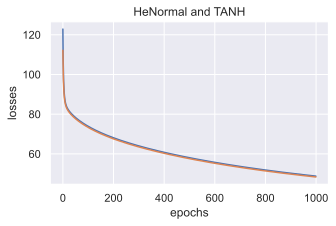

Loss =  48.81217956542969
Val_Loss =  48.378543853759766


In [81]:
fig, axes = plt.subplots(figsize=(5, 3))
axes.set_xlabel('epochs')
axes.set_ylabel('losses')
axes.plot(losses[['loss', 'val_loss']])
plt.title('HeNormal and TANH')
plt.show()
print('Loss = ', history.history['loss'][-1:][0])
print('Val_Loss = ', history.history['val_loss'][-1:][0])

In [82]:
#%tensorboard --logdir HeNormal_TANH/fit

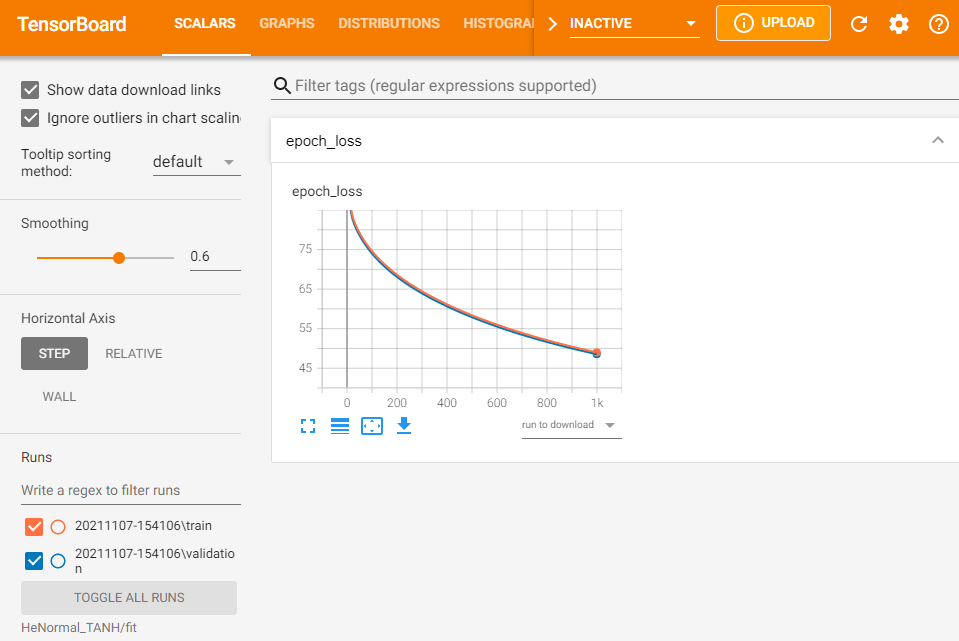

### HeNormal and ELU

In [83]:
model19 = create_model(5, Adam(learning_rate=0.0001), HeNormal, ELU)

log_dir = "HeNormal_ELU/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model19.fit(x=X_train,y=Y_train, validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[tensorboard_callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping])

losses = pd.DataFrame(model19.history.history)

Epoch 1/1000
11/11 [==============================] - 1s 62ms/step - loss: 128.5732 - val_loss: 113.3096
Epoch 2/1000
11/11 [==============================] - 0s 8ms/step - loss: 107.7832 - val_loss: 100.6783
Epoch 3/1000
11/11 [==============================] - 0s 8ms/step - loss: 97.4077 - val_loss: 92.4246
Epoch 4/1000
11/11 [==============================] - 0s 7ms/step - loss: 90.1164 - val_loss: 86.1778
Epoch 5/1000
11/11 [==============================] - 0s 7ms/step - loss: 84.4115 - val_loss: 81.0847
Epoch 6/1000
11/11 [==============================] - 0s 8ms/step - loss: 79.6297 - val_loss: 76.6564
Epoch 7/1000
11/11 [==============================] - 0s 8ms/step - loss: 75.3806 - val_loss: 72.6109
Epoch 8/1000
11/11 [==============================] - 0s 7ms/step - loss: 71.4383 - val_loss: 68.8033
Epoch 9/1000
11/11 [==============================] - 0s 7ms/step - loss: 67.6966 - val_loss: 65.1582
Epoch 10/1000
11/11 [==============================] - 0s 8ms/step - loss: 64

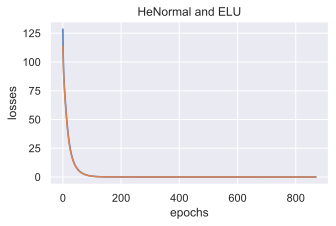

Loss =  0.017348870635032654
Val_Loss =  0.018172970041632652


In [84]:
fig, axes = plt.subplots(figsize=(5, 3))
axes.set_xlabel('epochs')
axes.set_ylabel('losses')
axes.plot(losses[['loss', 'val_loss']])
plt.title('HeNormal and ELU')
plt.show()
print('Loss = ', history.history['loss'][-1:][0])
print('Val_Loss = ', history.history['val_loss'][-1:][0])

In [85]:
#%tensorboard --logdir HeNormal_ELU/fit

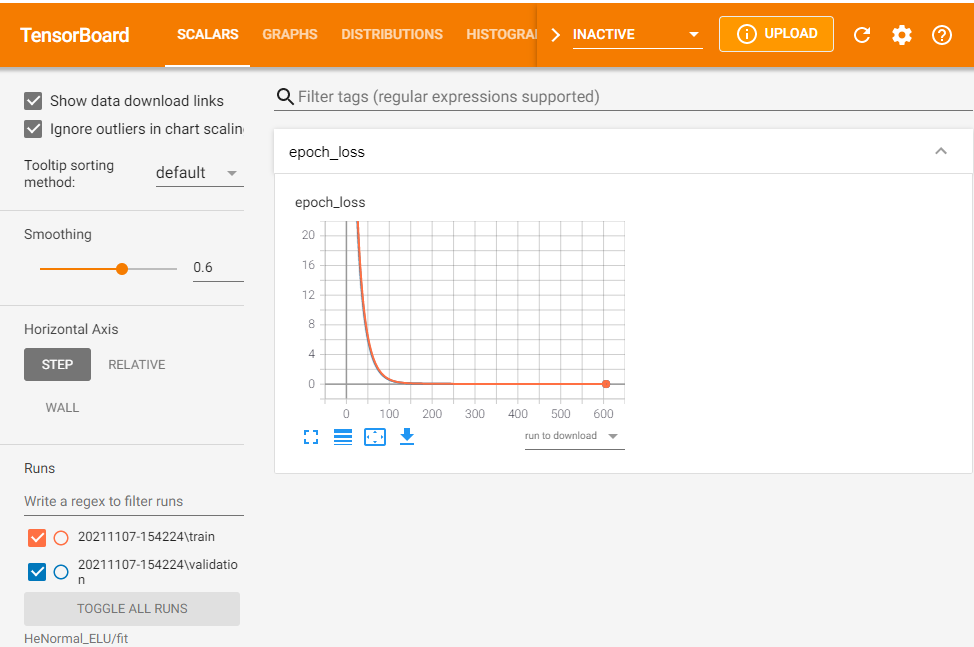

### HeNormal and SELU

In [86]:
model20 = create_model(5, Adam(learning_rate=0.0001), HeNormal, SELU)

log_dir = "HeNormal_SELU/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model20.fit(x=X_train,y=Y_train, validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[tensorboard_callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping])

losses = pd.DataFrame(model20.history.history)

Epoch 1/1000
11/11 [==============================] - 1s 50ms/step - loss: 117.0658 - val_loss: 98.0226
Epoch 2/1000
11/11 [==============================] - 0s 6ms/step - loss: 92.9285 - val_loss: 87.0415
Epoch 3/1000
11/11 [==============================] - 0s 7ms/step - loss: 84.5526 - val_loss: 80.7950
Epoch 4/1000
11/11 [==============================] - 0s 7ms/step - loss: 79.1650 - val_loss: 76.2289
Epoch 5/1000
11/11 [==============================] - 0s 8ms/step - loss: 74.9852 - val_loss: 72.4564
Epoch 6/1000
11/11 [==============================] - 0s 7ms/step - loss: 71.4045 - val_loss: 69.0905
Epoch 7/1000
11/11 [==============================] - 0s 7ms/step - loss: 68.1485 - val_loss: 65.9692
Epoch 8/1000
11/11 [==============================] - 0s 7ms/step - loss: 65.1045 - val_loss: 63.0214
Epoch 9/1000
11/11 [==============================] - 0s 7ms/step - loss: 62.2096 - val_loss: 60.2087
Epoch 10/1000
11/11 [==============================] - 0s 7ms/step - loss: 59.44

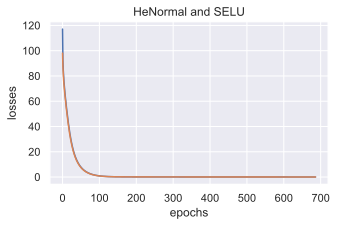

Loss =  0.016483573243021965
Val_Loss =  0.01729794777929783


In [87]:
fig, axes = plt.subplots(figsize=(5, 3))
axes.set_xlabel('epochs')
axes.set_ylabel('losses')
axes.plot(losses[['loss', 'val_loss']])
plt.title('HeNormal and SELU')
plt.show()
print('Loss = ', history.history['loss'][-1:][0])
print('Val_Loss = ', history.history['val_loss'][-1:][0])

In [88]:
#%tensorboard --logdir HeNormal_SELU/fit

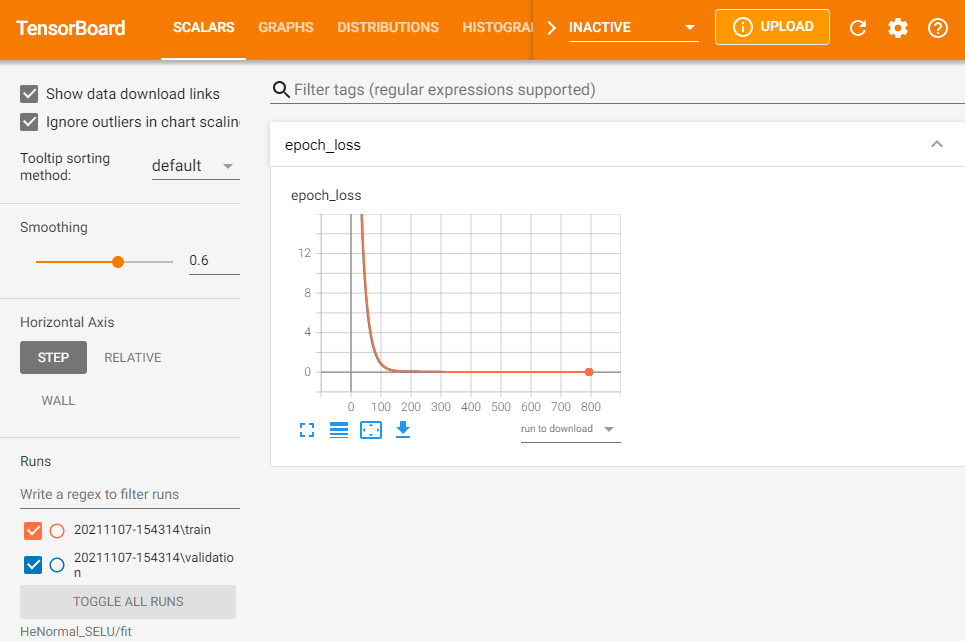

### HeNormal and GELU

In [89]:
model21 = create_model(5, Adam(learning_rate=0.0001), HeNormal, custom_gelu)

log_dir = "HeNormal_GELU/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model21.fit(x=X_train,y=Y_train, validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[tensorboard_callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping])

losses = pd.DataFrame(model21.history.history)

Epoch 1/1000
11/11 [==============================] - 1s 90ms/step - loss: 142.1037 - val_loss: 138.3153
Epoch 2/1000
11/11 [==============================] - 0s 7ms/step - loss: 136.0601 - val_loss: 130.2513
Epoch 3/1000
11/11 [==============================] - 0s 7ms/step - loss: 126.0810 - val_loss: 117.7144
Epoch 4/1000
11/11 [==============================] - 0s 7ms/step - loss: 112.1369 - val_loss: 102.8634
Epoch 5/1000
11/11 [==============================] - 0s 8ms/step - loss: 97.8417 - val_loss: 90.0899
Epoch 6/1000
11/11 [==============================] - 0s 7ms/step - loss: 86.2266 - val_loss: 79.9687
Epoch 7/1000
11/11 [==============================] - 0s 8ms/step - loss: 76.8987 - val_loss: 71.7179
Epoch 8/1000
11/11 [==============================] - 0s 8ms/step - loss: 69.2611 - val_loss: 64.8720
Epoch 9/1000
11/11 [==============================] - 0s 8ms/step - loss: 62.8309 - val_loss: 59.0355
Epoch 10/1000
11/11 [==============================] - 0s 8ms/step - loss

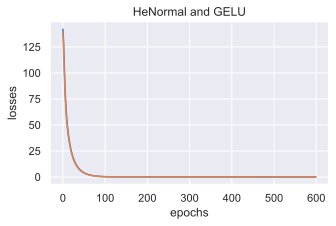

Loss =  0.01571970246732235
Val_Loss =  0.016915665939450264


In [90]:
fig, axes = plt.subplots(figsize=(5, 3))
axes.set_xlabel('epochs')
axes.set_ylabel('losses')
axes.plot(losses[['loss', 'val_loss']])
plt.title('HeNormal and GELU')
plt.show()
print('Loss = ', history.history['loss'][-1:][0])
print('Val_Loss = ', history.history['val_loss'][-1:][0])

In [91]:
#%tensorboard --logdir HeNormal_GELU/fit

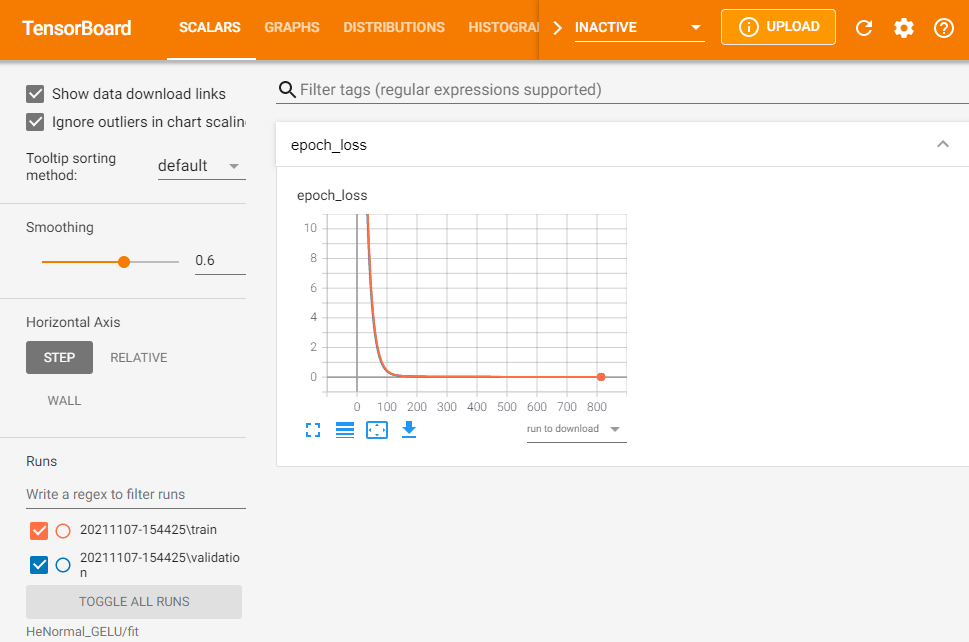

### LecunNormal and RELU

In [92]:
model22 = create_model(5, Adam(learning_rate=0.0001), LecunNormal, RELU)

log_dir = "LecunNormal_RELU/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model22.fit(x=X_train,y=Y_train, validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[tensorboard_callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping])

losses = pd.DataFrame(model22.history.history)

Epoch 1/1000
11/11 [==============================] - 1s 80ms/step - loss: 141.4647 - val_loss: 135.8883
Epoch 2/1000
11/11 [==============================] - 0s 8ms/step - loss: 132.8456 - val_loss: 126.7897
Epoch 3/1000
11/11 [==============================] - 0s 7ms/step - loss: 123.1399 - val_loss: 116.4203
Epoch 4/1000
11/11 [==============================] - 0s 7ms/step - loss: 112.3414 - val_loss: 105.3521
Epoch 5/1000
11/11 [==============================] - 0s 7ms/step - loss: 101.2861 - val_loss: 94.6097
Epoch 6/1000
11/11 [==============================] - 0s 9ms/step - loss: 90.8633 - val_loss: 84.8040
Epoch 7/1000
11/11 [==============================] - 0s 8ms/step - loss: 81.5296 - val_loss: 76.1585
Epoch 8/1000
11/11 [==============================] - 0s 7ms/step - loss: 73.3630 - val_loss: 68.6632
Epoch 9/1000
11/11 [==============================] - 0s 8ms/step - loss: 66.2811 - val_loss: 62.1523
Epoch 10/1000
11/11 [==============================] - 0s 8ms/step - los

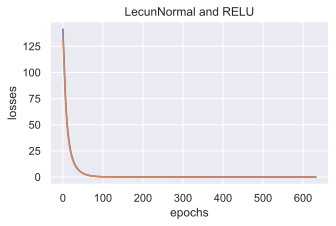

Loss =  0.015675852075219154
Val_Loss =  0.016443347558379173


In [93]:
fig, axes = plt.subplots(figsize=(5, 3))
axes.set_xlabel('epochs')
axes.set_ylabel('losses')
axes.plot(losses[['loss', 'val_loss']])
plt.title('LecunNormal and RELU')
plt.show()
print('Loss = ', history.history['loss'][-1:][0])
print('Val_Loss = ', history.history['val_loss'][-1:][0])

In [94]:
#%tensorboard --logdir LecunNormal_RELU/fit

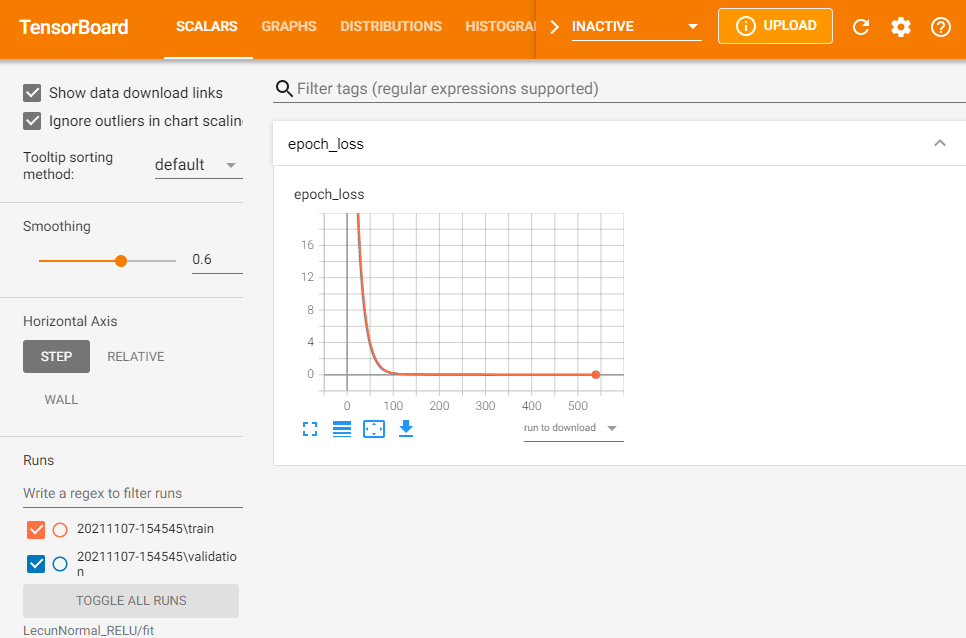

### LecunNormal and SIGMOID

In [95]:
model23 = create_model(5, Adam(learning_rate=0.0001), LecunNormal, SIGMOID)

log_dir = "LecunNormal_SIGMOID/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model23.fit(x=X_train,y=Y_train, validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[tensorboard_callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping])

losses = pd.DataFrame(model23.history.history)

Epoch 1/1000
11/11 [==============================] - 1s 58ms/step - loss: 123.5556 - val_loss: 120.4712
Epoch 2/1000
11/11 [==============================] - 0s 9ms/step - loss: 119.6233 - val_loss: 117.0251
Epoch 3/1000
11/11 [==============================] - 0s 8ms/step - loss: 116.4515 - val_loss: 114.2099
Epoch 4/1000
11/11 [==============================] - 0s 7ms/step - loss: 113.8318 - val_loss: 111.8456
Epoch 5/1000
11/11 [==============================] - 0s 7ms/step - loss: 111.6081 - val_loss: 109.8088
Epoch 6/1000
11/11 [==============================] - 0s 7ms/step - loss: 109.6754 - val_loss: 108.0202
Epoch 7/1000
11/11 [==============================] - 0s 7ms/step - loss: 107.9681 - val_loss: 106.4282
Epoch 8/1000
11/11 [==============================] - 0s 7ms/step - loss: 106.4435 - val_loss: 105.0003
Epoch 9/1000
11/11 [==============================] - 0s 7ms/step - loss: 105.0724 - val_loss: 103.7142
Epoch 10/1000
11/11 [==============================] - 0s 7ms/s

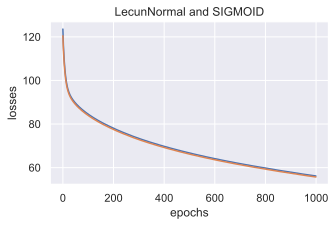

Loss =  56.1624641418457
Val_Loss =  55.696292877197266


In [96]:
fig, axes = plt.subplots(figsize=(5, 3))
axes.set_xlabel('epochs')
axes.set_ylabel('losses')
axes.plot(losses[['loss', 'val_loss']])
plt.title('LecunNormal and SIGMOID')
plt.show()
print('Loss = ', history.history['loss'][-1:][0])
print('Val_Loss = ', history.history['val_loss'][-1:][0])

In [97]:
#%tensorboard --logdir LecunNormal_SIGMOID/fit

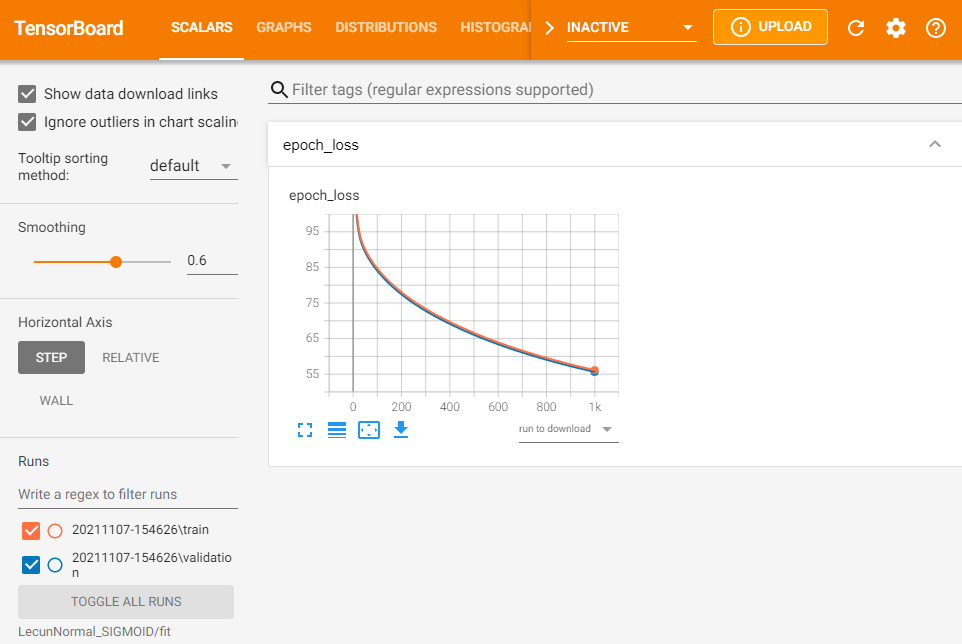

### LecunNormal and TANH

In [98]:
model24 = create_model(5, Adam(learning_rate=0.0001), LecunNormal, TANH)

log_dir = "LecunNormal_TANH/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model24.fit(x=X_train,y=Y_train, validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[tensorboard_callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping])

losses = pd.DataFrame(model24.history.history)

Epoch 1/1000
11/11 [==============================] - 1s 57ms/step - loss: 127.9650 - val_loss: 115.6422
Epoch 2/1000
11/11 [==============================] - 0s 7ms/step - loss: 111.2630 - val_loss: 105.1207
Epoch 3/1000
11/11 [==============================] - 0s 7ms/step - loss: 102.9506 - val_loss: 99.1061
Epoch 4/1000
11/11 [==============================] - 0s 7ms/step - loss: 97.9706 - val_loss: 95.3049
Epoch 5/1000
11/11 [==============================] - 0s 7ms/step - loss: 94.7304 - val_loss: 92.6976
Epoch 6/1000
11/11 [==============================] - 0s 7ms/step - loss: 92.4410 - val_loss: 90.7989
Epoch 7/1000
11/11 [==============================] - 0s 8ms/step - loss: 90.7435 - val_loss: 89.3576
Epoch 8/1000
11/11 [==============================] - 0s 8ms/step - loss: 89.4373 - val_loss: 88.2205
Epoch 9/1000
11/11 [==============================] - 0s 10ms/step - loss: 88.3916 - val_loss: 87.2973
Epoch 10/1000
11/11 [==============================] - 0s 14ms/step - loss:

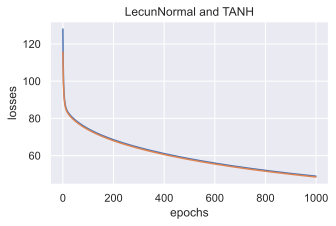

Loss =  48.955909729003906
Val_Loss =  48.52156448364258


In [99]:
fig, axes = plt.subplots(figsize=(5, 3))
axes.set_xlabel('epochs')
axes.set_ylabel('losses')
axes.plot(losses[['loss', 'val_loss']])
plt.title('LecunNormal and TANH')
plt.show()
print('Loss = ', history.history['loss'][-1:][0])
print('Val_Loss = ', history.history['val_loss'][-1:][0])

In [100]:
#%tensorboard --logdir LecunNormal_TANH/fit

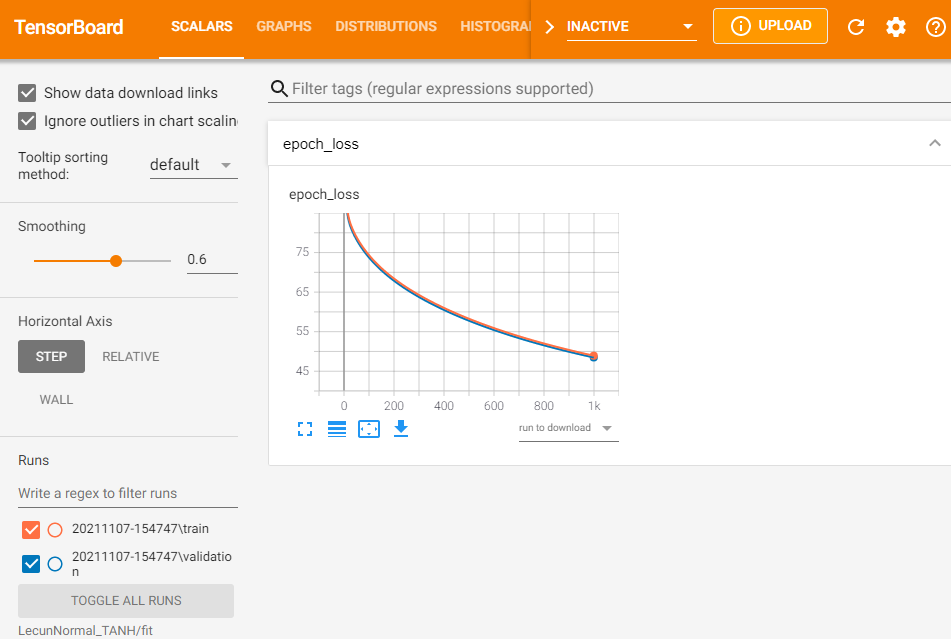

### LecunNormal and ELU

In [101]:
model25 = create_model(5, Adam(learning_rate=0.0001), LecunNormal, ELU)

log_dir = "LecunNormal_ELU/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model25.fit(x=X_train,y=Y_train, validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[tensorboard_callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping])

losses = pd.DataFrame(model25.history.history)

Epoch 1/1000
11/11 [==============================] - 1s 48ms/step - loss: 135.0590 - val_loss: 121.6009
Epoch 2/1000
11/11 [==============================] - 0s 6ms/step - loss: 115.9908 - val_loss: 108.3865
Epoch 3/1000
11/11 [==============================] - 0s 6ms/step - loss: 104.7793 - val_loss: 99.1942
Epoch 4/1000
11/11 [==============================] - 0s 6ms/step - loss: 96.5630 - val_loss: 92.0960
Epoch 5/1000
11/11 [==============================] - 0s 6ms/step - loss: 90.0501 - val_loss: 86.2486
Epoch 6/1000
11/11 [==============================] - 0s 7ms/step - loss: 84.5397 - val_loss: 81.1500
Epoch 7/1000
11/11 [==============================] - 0s 7ms/step - loss: 79.6554 - val_loss: 76.5480
Epoch 8/1000
11/11 [==============================] - 0s 7ms/step - loss: 75.1996 - val_loss: 72.2884
Epoch 9/1000
11/11 [==============================] - 0s 7ms/step - loss: 71.0376 - val_loss: 68.2579
Epoch 10/1000
11/11 [==============================] - 0s 7ms/step - loss: 6

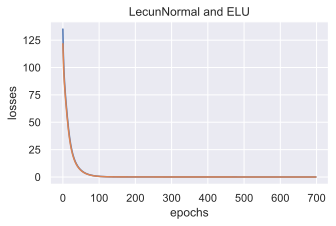

Loss =  0.017742011696100235
Val_Loss =  0.01802346482872963


In [102]:
fig, axes = plt.subplots(figsize=(5, 3))
axes.set_xlabel('epochs')
axes.set_ylabel('losses')
axes.plot(losses[['loss', 'val_loss']])
plt.title('LecunNormal and ELU')
plt.show()
print('Loss = ', history.history['loss'][-1:][0])
print('Val_Loss = ', history.history['val_loss'][-1:][0])

In [103]:
#%tensorboard --logdir LecunNormal_ELU/fit

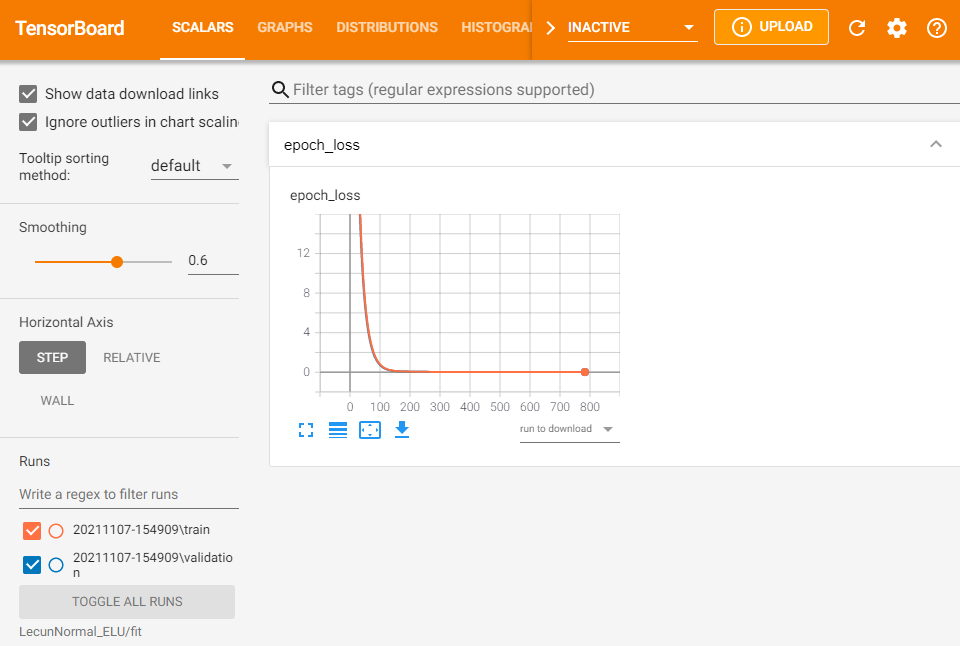

### LecunNormal and SELU

In [105]:
model26= create_model(5, Adam(learning_rate=0.0001), LecunNormal, SELU)

log_dir = "LecunNormal_SELU/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model26.fit(x=X_train,y=Y_train, validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[tensorboard_callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping])

losses = pd.DataFrame(model26.history.history)

Epoch 1/1000
11/11 [==============================] - 1s 60ms/step - loss: 116.6803 - val_loss: 96.8825
Epoch 2/1000
11/11 [==============================] - 0s 8ms/step - loss: 92.5288 - val_loss: 86.5229
Epoch 3/1000
11/11 [==============================] - 0s 8ms/step - loss: 84.6162 - val_loss: 80.9280
Epoch 4/1000
11/11 [==============================] - 0s 8ms/step - loss: 79.7610 - val_loss: 76.9686
Epoch 5/1000
11/11 [==============================] - 0s 8ms/step - loss: 76.1594 - val_loss: 73.8228
Epoch 6/1000
11/11 [==============================] - 0s 8ms/step - loss: 73.1945 - val_loss: 71.0979
Epoch 7/1000
11/11 [==============================] - 0s 8ms/step - loss: 70.5587 - val_loss: 68.5824
Epoch 8/1000
11/11 [==============================] - 0s 8ms/step - loss: 68.0807 - val_loss: 66.1691
Epoch 9/1000
11/11 [==============================] - 0s 8ms/step - loss: 65.6837 - val_loss: 63.8129
Epoch 10/1000
11/11 [==============================] - 0s 8ms/step - loss: 63.32

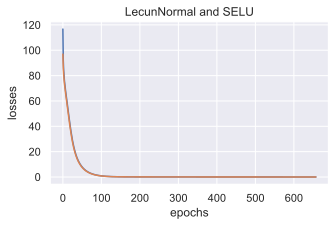

Loss =  0.01752931997179985
Val_Loss =  0.018540257588028908


In [106]:
fig, axes = plt.subplots(figsize=(5, 3))
axes.set_xlabel('epochs')
axes.set_ylabel('losses')
axes.plot(losses[['loss', 'val_loss']])
plt.title('LecunNormal and SELU')
plt.show()
print('Loss = ', history.history['loss'][-1:][0])
print('Val_Loss = ', history.history['val_loss'][-1:][0])

In [107]:
#%tensorboard --logdir LecunNormal_SELU/fit

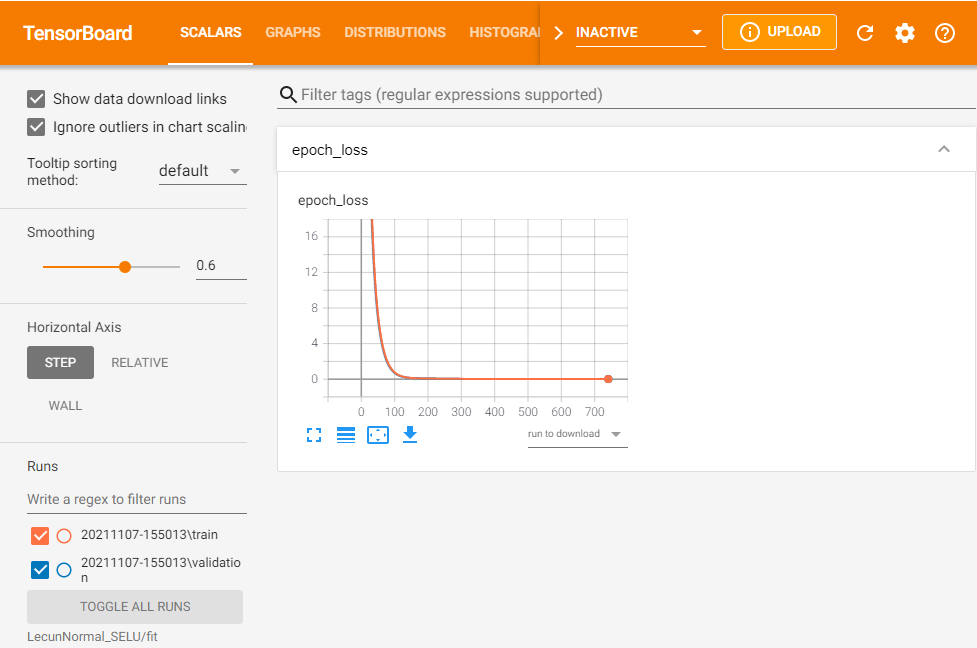

### LecunNormal and GELU

In [108]:
model27 = create_model(5, Adam(learning_rate=0.0001), LecunNormal, custom_gelu)

log_dir = "LecunNormal_GELU/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model27.fit(x=X_train,y=Y_train, validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[tensorboard_callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping])

losses = pd.DataFrame(model27.history.history)

Epoch 1/1000
11/11 [==============================] - 1s 72ms/step - loss: 144.2433 - val_loss: 141.9964
Epoch 2/1000
11/11 [==============================] - 0s 7ms/step - loss: 141.1531 - val_loss: 137.6139
Epoch 3/1000
11/11 [==============================] - 0s 7ms/step - loss: 135.4594 - val_loss: 129.7044
Epoch 4/1000
11/11 [==============================] - 0s 7ms/step - loss: 125.6343 - val_loss: 117.1805
Epoch 5/1000
11/11 [==============================] - 0s 7ms/step - loss: 111.3989 - val_loss: 101.2835
Epoch 6/1000
11/11 [==============================] - 0s 7ms/step - loss: 95.5784 - val_loss: 86.8450
Epoch 7/1000
11/11 [==============================] - 0s 8ms/step - loss: 82.6357 - val_loss: 76.0347
Epoch 8/1000
11/11 [==============================] - 0s 8ms/step - loss: 72.9696 - val_loss: 67.8003
Epoch 9/1000
11/11 [==============================] - 0s 8ms/step - loss: 65.3784 - val_loss: 61.0566
Epoch 10/1000
11/11 [==============================] - 0s 8ms/step - lo

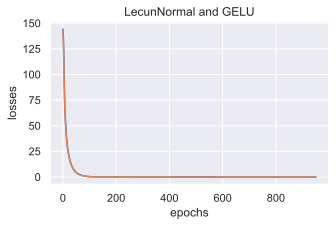

Loss =  0.015956994146108627
Val_Loss =  0.016861608251929283


In [109]:
fig, axes = plt.subplots(figsize=(5, 3))
axes.set_xlabel('epochs')
axes.set_ylabel('losses')
axes.plot(losses[['loss', 'val_loss']])
plt.title('LecunNormal and GELU')
plt.show()
print('Loss = ', history.history['loss'][-1:][0])
print('Val_Loss = ', history.history['val_loss'][-1:][0])

In [110]:
#%tensorboard --logdir LecunNormal_GELU/fit

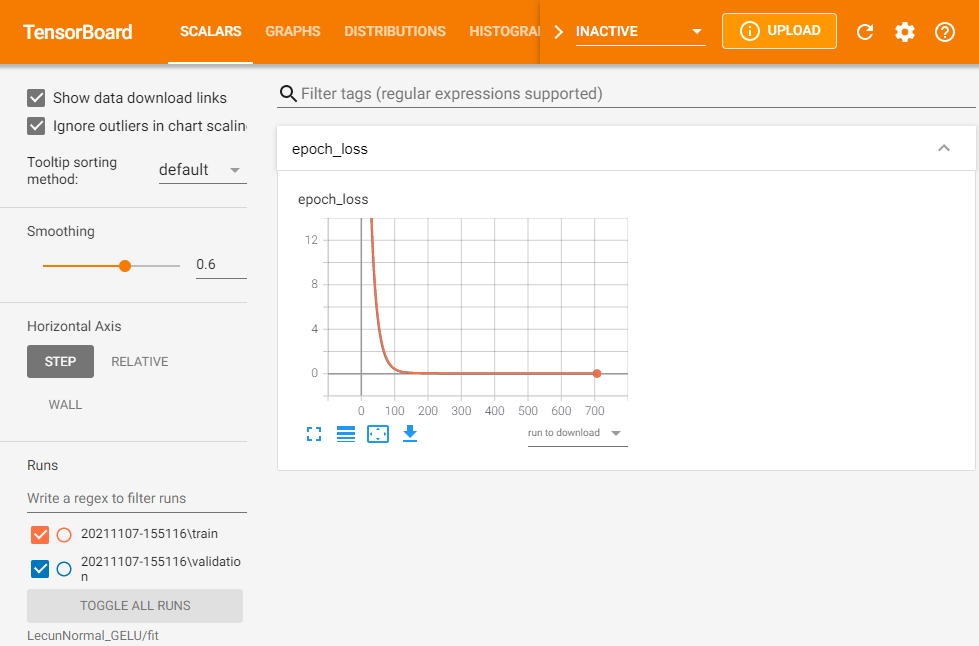

In [111]:
print('LOSSES:')
print('-'*55)
print('RandomNormal and RELU    =', model4.evaluate(X_train, Y_train, batch_size=128,verbose=0)) 
print('RandomNormal and SIGMOID =', model5.evaluate(X_train, Y_train, batch_size=128,verbose=0)) 
print('RandomNormal and TANH    =', model6.evaluate(X_train, Y_train, batch_size=128,verbose=0)) 
print('RandomNormal and ELU     =', model7.evaluate(X_train, Y_train, batch_size=128,verbose=0)) 
print('RandomNormal and SELU    =', model8.evaluate(X_train, Y_train, batch_size=128,verbose=0)) 
print('RandomNormal and GELU    =', model9.evaluate(X_train, Y_train, batch_size=128,verbose=0)) 
print('-'*55)
print('GlorotNormal and RELU    =', model10.evaluate(X_train, Y_train, batch_size=128,verbose=0)) 
print('GlorotNormal and SIGMOID =', model11.evaluate(X_train, Y_train, batch_size=128,verbose=0)) 
print('GlorotNormal and TANH    =', model12.evaluate(X_train, Y_train, batch_size=128,verbose=0)) 
print('GlorotNormal and ELU     =', model13.evaluate(X_train, Y_train, batch_size=128,verbose=0)) 
print('GlorotNormal and SELU    =', model14.evaluate(X_train, Y_train, batch_size=128,verbose=0)) 
print('GlorotNormal and GELU    =', model15.evaluate(X_train, Y_train, batch_size=128,verbose=0)) 
print('-'*55)
print('HeNormal and RELU        =', model16.evaluate(X_train, Y_train, batch_size=128,verbose=0)) 
print('HeNormal and SIGMOID     =', model17.evaluate(X_train, Y_train, batch_size=128,verbose=0)) 
print('HeNormal and TANH        =', model18.evaluate(X_train, Y_train, batch_size=128,verbose=0)) 
print('HeNormal and ELU         =', model19.evaluate(X_train, Y_train, batch_size=128,verbose=0)) 
print('HeNormal and SELU        =', model20.evaluate(X_train, Y_train, batch_size=128,verbose=0)) 
print('HeNormal and GELU        =', model21.evaluate(X_train, Y_train, batch_size=128,verbose=0)) 
print('-'*55)
print('LecunNormal and RELU     =', model22.evaluate(X_train, Y_train, batch_size=128,verbose=0)) 
print('LecunNormal and SIGMOID  =', model23.evaluate(X_train, Y_train, batch_size=128,verbose=0)) 
print('LecunNormal and TANH     =', model24.evaluate(X_train, Y_train, batch_size=128,verbose=0)) 
print('LecunNormal and ELU      =', model25.evaluate(X_train, Y_train, batch_size=128,verbose=0)) 
print('LecunNormal and SELU     =', model26.evaluate(X_train, Y_train, batch_size=128,verbose=0)) 
print('LecunNormal and GELU     =', model27.evaluate(X_train, Y_train, batch_size=128,verbose=0)) 

LOSSES:
-------------------------------------------------------
RandomNormal and RELU    = 0.016532042995095253
RandomNormal and SIGMOID = 57.129783630371094
RandomNormal and TANH    = 48.871002197265625
RandomNormal and ELU     = 0.019945936277508736
RandomNormal and SELU    = 0.016217391937971115
RandomNormal and GELU    = 0.016533944755792618
-------------------------------------------------------
GlorotNormal and RELU    = 0.01553075760602951
GlorotNormal and SIGMOID = 57.213157653808594
GlorotNormal and TANH    = 48.97648620605469
GlorotNormal and ELU     = 0.018219172954559326
GlorotNormal and SELU    = 0.017425671219825745
GlorotNormal and GELU    = 0.017125403508543968
-------------------------------------------------------
HeNormal and RELU        = 0.014867056161165237
HeNormal and SIGMOID     = 56.851070404052734
HeNormal and TANH        = 48.76161193847656
HeNormal and ELU         = 0.017426056787371635
HeNormal and SELU        = 0.016563287004828453
HeNormal and GELU      